# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw1/data), and upload data manually to the workspace.

!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Some Utility Functions

You do not need to modify this part.

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size],
                                        generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

# Dataset

In [3]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)


    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [4]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        #input_dim is the num of features we selected
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm1d(10),
            nn.Dropout(0.1),
            
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

features = pd.read_csv('./covid.train.csv')
x_data, y_data = features.iloc[:, 0:117], features.iloc[:, 117]

#try choose your k best features
k = 24
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)

#result.scores_ inclues scores for each features
#np.argsort sort scores in ascending order by index, we reverse it to make it descending.
idx = np.argsort(result.scores_)[::-1]
print(f'Top {k} Best feature score ')
print(result.scores_[idx[:k]])

print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])

selected_idx = list(np.sort(idx[:k]))
print(selected_idx)
print(x_data.columns[selected_idx])

Top 24 Best feature score 
[90072.43401367 42336.37370139 26889.70377033 18870.55811361
 11290.79919656 10849.62638725 10420.334481   10365.26105926
 10055.85024148  9859.62690961  9636.4254885   9330.74236337
  9180.16305651  8703.90128488  7857.10815311  7840.26399997
  7669.80626316  7634.02832221  7471.14168359  7427.81602428
  7379.57519499  7350.43226583  7200.10012107  7189.72334257]

Top 24 Best feature index 
[101  85  69  53 104  88 105  72  89  56  73  40  57  41 103 102  87  86
  71  70  55  54  39  38]

Top 24 Best feature name
Index(['tested_positive.3', 'tested_positive.2', 'tested_positive.1',
       'tested_positive', 'hh_cmnty_cli.4', 'hh_cmnty_cli.3',
       'nohh_cmnty_cli.4', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.3',
       'hh_cmnty_cli.1', 'nohh_cmnty_cli.2', 'hh_cmnty_cli',
       'nohh_cmnty_cli.1', 'nohh_cmnty_cli', 'ili.4', 'cli.4', 'ili.3',
       'cli.3', 'ili.2', 'cli.2', 'ili.1', 'cli.1', 'ili', 'cli'],
      dtype='object')
[38, 39, 40, 41, 53, 54, 55, 56, 5

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = selected_idx
        # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [7]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    #optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']*50,
                                 weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                        T_0=2, T_mult=2, eta_min=config['learning_rate'])

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
            
        scheduler.step() 

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_losses.append(mean_train_loss)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_losses.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            break
    return train_losses, val_losses

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-5,              
    'early_stop': 500,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [9]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid.train.csv').values, pd.read_csv('./covid.test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, False)


#normalization
x_min, x_max = x_train.min(axis=0), x_train.max(axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_valid = (x_valid - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

print(f"""train_data size: {x_train.shape} 
valid_data size: {x_valid.shape} 
test_data size: {x_test.shape}""")
# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2160, 118) 
valid_data size: (539, 118) 
test_data size: (1078, 117)
train_data size: (2160, 24) 
valid_data size: (539, 24) 
test_data size: (1078, 24)
number of features: 24


# Start training!

In [10]:
model = My_Model(input_dim=x_train.shape[1]).to(device) 
#put your model and data on the same computation device.
train_losses, val_losses = trainer(train_loader, valid_loader, model, config, device)

Epoch [1/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 136.83it/s, loss=134]


Epoch [1/5000]: Train loss: 132.5247, Valid loss: 141.1235
Saving model with loss 141.124...


Epoch [2/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 174.15it/s, loss=123]


Epoch [2/5000]: Train loss: 127.6187, Valid loss: 141.5049


Epoch [3/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 143.30it/s, loss=120]


Epoch [3/5000]: Train loss: 124.6155, Valid loss: 140.6920
Saving model with loss 140.692...


Epoch [4/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 147.19it/s, loss=122]


Epoch [4/5000]: Train loss: 121.3758, Valid loss: 144.2822


Epoch [5/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 138.48it/s, loss=108]


Epoch [5/5000]: Train loss: 117.5981, Valid loss: 136.7457
Saving model with loss 136.746...


Epoch [6/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 155.66it/s, loss=113]


Epoch [6/5000]: Train loss: 116.4313, Valid loss: 117.8255
Saving model with loss 117.826...


Epoch [7/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 160.00it/s, loss=118]


Epoch [7/5000]: Train loss: 114.8116, Valid loss: 113.3341
Saving model with loss 113.334...


Epoch [8/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 162.40it/s, loss=79.9]

Epoch [8/5000]: Train loss: 108.0119, Valid loss: 110.8056


Saving model with loss 110.806...


Epoch [9/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 162.03it/s, loss=96.2]


Epoch [9/5000]: Train loss: 105.4677, Valid loss: 112.1348


Epoch [10/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 60.17it/s, loss=89.5]


Epoch [10/5000]: Train loss: 101.6625, Valid loss: 109.6735
Saving model with loss 109.673...


Epoch [11/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 158.59it/s, loss=96]


Epoch [11/5000]: Train loss: 98.8812, Valid loss: 100.1811
Saving model with loss 100.181...


Epoch [12/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.71it/s, loss=93.5]


Epoch [12/5000]: Train loss: 96.4170, Valid loss: 102.8986


Epoch [13/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 162.66it/s, loss=87.8]


Epoch [13/5000]: Train loss: 95.9181, Valid loss: 102.5472


Epoch [14/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 161.17it/s, loss=107]


Epoch [14/5000]: Train loss: 95.5993, Valid loss: 102.7694


Epoch [15/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 161.53it/s, loss=91.1]


Epoch [15/5000]: Train loss: 93.3729, Valid loss: 94.9381
Saving model with loss 94.938...


Epoch [16/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 158.51it/s, loss=88.1]


Epoch [16/5000]: Train loss: 87.7941, Valid loss: 94.4703
Saving model with loss 94.470...


Epoch [17/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 158.53it/s, loss=73]


Epoch [17/5000]: Train loss: 82.1591, Valid loss: 82.3469
Saving model with loss 82.347...


Epoch [18/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.71it/s, loss=67.6]


Epoch [18/5000]: Train loss: 77.8235, Valid loss: 77.9618
Saving model with loss 77.962...


Epoch [19/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 140.29it/s, loss=75.1]


Epoch [19/5000]: Train loss: 73.5592, Valid loss: 78.6688


Epoch [20/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 150.86it/s, loss=71.1]


Epoch [20/5000]: Train loss: 69.2800, Valid loss: 73.0024
Saving model with loss 73.002...


Epoch [21/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 150.97it/s, loss=65]


Epoch [21/5000]: Train loss: 66.5103, Valid loss: 71.8029
Saving model with loss 71.803...


Epoch [22/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.40it/s, loss=72.3]


Epoch [22/5000]: Train loss: 64.0080, Valid loss: 68.8636
Saving model with loss 68.864...


Epoch [23/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 149.85it/s, loss=64.4]


Epoch [23/5000]: Train loss: 61.3909, Valid loss: 65.6223
Saving model with loss 65.622...


Epoch [24/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 149.99it/s, loss=55.2]


Epoch [24/5000]: Train loss: 59.0488, Valid loss: 61.2453
Saving model with loss 61.245...


Epoch [25/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 152.49it/s, loss=59]


Epoch [25/5000]: Train loss: 57.6207, Valid loss: 61.3009


Epoch [26/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 137.77it/s, loss=59.1]


Epoch [26/5000]: Train loss: 56.7813, Valid loss: 57.5203
Saving model with loss 57.520...


Epoch [27/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.60it/s, loss=59.9]


Epoch [27/5000]: Train loss: 56.6545, Valid loss: 58.4372


Epoch [28/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 136.50it/s, loss=74.4]


Epoch [28/5000]: Train loss: 57.0013, Valid loss: 57.7548


Epoch [29/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 149.93it/s, loss=62.8]


Epoch [29/5000]: Train loss: 56.2671, Valid loss: 57.9230


Epoch [30/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.65it/s, loss=54.2]


Epoch [30/5000]: Train loss: 55.5382, Valid loss: 55.2388
Saving model with loss 55.239...


Epoch [31/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 129.17it/s, loss=44.5]


Epoch [31/5000]: Train loss: 53.1211, Valid loss: 53.1433
Saving model with loss 53.143...


Epoch [32/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 150.83it/s, loss=46.2]


Epoch [32/5000]: Train loss: 50.3733, Valid loss: 50.7439
Saving model with loss 50.744...


Epoch [33/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.89it/s, loss=48.2]


Epoch [33/5000]: Train loss: 48.0255, Valid loss: 53.9636


Epoch [34/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 150.74it/s, loss=42.2]


Epoch [34/5000]: Train loss: 45.2769, Valid loss: 47.8331
Saving model with loss 47.833...


Epoch [35/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 152.02it/s, loss=47.1]


Epoch [35/5000]: Train loss: 44.5144, Valid loss: 42.8450
Saving model with loss 42.845...


Epoch [36/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.36it/s, loss=44.2]


Epoch [36/5000]: Train loss: 43.4017, Valid loss: 43.3088


Epoch [37/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.28it/s, loss=49.1]


Epoch [37/5000]: Train loss: 42.3858, Valid loss: 43.5640


Epoch [38/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.27it/s, loss=47.8]


Epoch [38/5000]: Train loss: 41.8758, Valid loss: 42.0311
Saving model with loss 42.031...


Epoch [39/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 149.75it/s, loss=39.4]


Epoch [39/5000]: Train loss: 40.0248, Valid loss: 41.0389
Saving model with loss 41.039...


Epoch [40/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.80it/s, loss=50.3]


Epoch [40/5000]: Train loss: 40.1151, Valid loss: 42.0916


Epoch [41/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 152.90it/s, loss=44.4]


Epoch [41/5000]: Train loss: 39.0814, Valid loss: 38.0786
Saving model with loss 38.079...


Epoch [42/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.63it/s, loss=33.1]


Epoch [42/5000]: Train loss: 38.3893, Valid loss: 38.8280


Epoch [43/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.77it/s, loss=37.2]


Epoch [43/5000]: Train loss: 37.6433, Valid loss: 37.2881
Saving model with loss 37.288...


Epoch [44/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 144.86it/s, loss=39.6]


Epoch [44/5000]: Train loss: 37.1620, Valid loss: 35.9379
Saving model with loss 35.938...


Epoch [45/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 149.25it/s, loss=31.9]


Epoch [45/5000]: Train loss: 36.7500, Valid loss: 33.6155
Saving model with loss 33.615...


Epoch [46/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.76it/s, loss=30.7]


Epoch [46/5000]: Train loss: 36.3521, Valid loss: 34.8761


Epoch [47/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 154.48it/s, loss=33]


Epoch [47/5000]: Train loss: 35.8182, Valid loss: 33.0167
Saving model with loss 33.017...


Epoch [48/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.51it/s, loss=32.7]


Epoch [48/5000]: Train loss: 35.1246, Valid loss: 31.8507
Saving model with loss 31.851...


Epoch [49/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.96it/s, loss=37.7]


Epoch [49/5000]: Train loss: 35.7103, Valid loss: 33.1852


Epoch [50/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 150.42it/s, loss=29.9]


Epoch [50/5000]: Train loss: 33.6643, Valid loss: 33.0424


Epoch [51/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.96it/s, loss=30.6]


Epoch [51/5000]: Train loss: 34.4566, Valid loss: 31.7656
Saving model with loss 31.766...


Epoch [52/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.08it/s, loss=33.7]


Epoch [52/5000]: Train loss: 34.5156, Valid loss: 31.5039
Saving model with loss 31.504...


Epoch [53/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.85it/s, loss=37.5]


Epoch [53/5000]: Train loss: 34.2100, Valid loss: 32.5594


Epoch [54/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 152.89it/s, loss=33]


Epoch [54/5000]: Train loss: 33.9019, Valid loss: 30.1556
Saving model with loss 30.156...


Epoch [55/5000]: 100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 55.29it/s, loss=37]


Epoch [55/5000]: Train loss: 34.1056, Valid loss: 28.8117
Saving model with loss 28.812...


Epoch [56/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 160.98it/s, loss=39.8]


Epoch [56/5000]: Train loss: 33.8425, Valid loss: 31.3228


Epoch [57/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.03it/s, loss=33.4]


Epoch [57/5000]: Train loss: 33.9337, Valid loss: 32.2976


Epoch [58/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.70it/s, loss=33.1]


Epoch [58/5000]: Train loss: 33.9328, Valid loss: 30.4715


Epoch [59/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.68it/s, loss=32.1]


Epoch [59/5000]: Train loss: 33.5489, Valid loss: 31.5027


Epoch [60/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 159.44it/s, loss=32.9]


Epoch [60/5000]: Train loss: 33.6070, Valid loss: 30.5010


Epoch [61/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 163.01it/s, loss=42.7]


Epoch [61/5000]: Train loss: 33.8525, Valid loss: 30.9038


Epoch [62/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.66it/s, loss=30.5]


Epoch [62/5000]: Train loss: 33.3941, Valid loss: 31.4522


Epoch [63/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.75it/s, loss=35.2]


Epoch [63/5000]: Train loss: 33.2463, Valid loss: 30.7458


Epoch [64/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.99it/s, loss=28.8]


Epoch [64/5000]: Train loss: 32.5465, Valid loss: 32.8494


Epoch [65/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 130.76it/s, loss=28.5]


Epoch [65/5000]: Train loss: 31.7359, Valid loss: 29.4409


Epoch [66/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.64it/s, loss=37.3]


Epoch [66/5000]: Train loss: 31.9513, Valid loss: 31.7036


Epoch [67/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.39it/s, loss=32.7]


Epoch [67/5000]: Train loss: 30.9024, Valid loss: 28.7106
Saving model with loss 28.711...


Epoch [68/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 157.89it/s, loss=25]


Epoch [68/5000]: Train loss: 29.8806, Valid loss: 27.6723
Saving model with loss 27.672...


Epoch [69/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 151.63it/s, loss=35]


Epoch [69/5000]: Train loss: 29.3389, Valid loss: 27.6762


Epoch [70/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.50it/s, loss=32.2]


Epoch [70/5000]: Train loss: 28.3560, Valid loss: 27.9542


Epoch [71/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 144.78it/s, loss=24.4]


Epoch [71/5000]: Train loss: 27.2663, Valid loss: 26.3927
Saving model with loss 26.393...


Epoch [72/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 156.62it/s, loss=37]


Epoch [72/5000]: Train loss: 27.1547, Valid loss: 26.7248


Epoch [73/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 159.49it/s, loss=23.7]


Epoch [73/5000]: Train loss: 26.0962, Valid loss: 23.3645
Saving model with loss 23.364...


Epoch [74/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 152.11it/s, loss=24.5]


Epoch [74/5000]: Train loss: 25.2695, Valid loss: 24.4196


Epoch [75/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.12it/s, loss=25.9]


Epoch [75/5000]: Train loss: 24.3407, Valid loss: 23.4293


Epoch [76/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.39it/s, loss=29.5]


Epoch [76/5000]: Train loss: 23.6637, Valid loss: 21.2259
Saving model with loss 21.226...


Epoch [77/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 150.32it/s, loss=23.7]


Epoch [77/5000]: Train loss: 23.0678, Valid loss: 20.5766
Saving model with loss 20.577...


Epoch [78/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.84it/s, loss=18.2]


Epoch [78/5000]: Train loss: 21.7856, Valid loss: 19.2381
Saving model with loss 19.238...


Epoch [79/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 162.04it/s, loss=21.5]


Epoch [79/5000]: Train loss: 21.5807, Valid loss: 19.5745


Epoch [80/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 140.63it/s, loss=21.6]


Epoch [80/5000]: Train loss: 20.9236, Valid loss: 20.6624


Epoch [81/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 159.68it/s, loss=17.7]


Epoch [81/5000]: Train loss: 19.7905, Valid loss: 16.8673
Saving model with loss 16.867...


Epoch [82/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 162.35it/s, loss=17.5]


Epoch [82/5000]: Train loss: 19.4723, Valid loss: 17.7374


Epoch [83/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.32it/s, loss=20.4]


Epoch [83/5000]: Train loss: 18.7281, Valid loss: 17.1832


Epoch [84/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 158.23it/s, loss=16.2]


Epoch [84/5000]: Train loss: 18.2777, Valid loss: 13.5105
Saving model with loss 13.510...


Epoch [85/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 156.11it/s, loss=21]


Epoch [85/5000]: Train loss: 17.5525, Valid loss: 14.3456


Epoch [86/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.82it/s, loss=13.2]


Epoch [86/5000]: Train loss: 16.6543, Valid loss: 13.1263
Saving model with loss 13.126...


Epoch [87/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 137.46it/s, loss=14.9]


Epoch [87/5000]: Train loss: 16.0340, Valid loss: 13.0274
Saving model with loss 13.027...


Epoch [88/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 147.71it/s, loss=19.4]


Epoch [88/5000]: Train loss: 15.4617, Valid loss: 12.0894
Saving model with loss 12.089...


Epoch [89/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.19it/s, loss=14.9]


Epoch [89/5000]: Train loss: 15.1846, Valid loss: 11.7726
Saving model with loss 11.773...


Epoch [90/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 150.07it/s, loss=15.2]


Epoch [90/5000]: Train loss: 14.0560, Valid loss: 12.0671


Epoch [91/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 128.78it/s, loss=10.6]


Epoch [91/5000]: Train loss: 13.7452, Valid loss: 10.6431
Saving model with loss 10.643...


Epoch [92/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 134.73it/s, loss=15]


Epoch [92/5000]: Train loss: 13.7981, Valid loss: 10.3143
Saving model with loss 10.314...


Epoch [93/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 143.89it/s, loss=10.2]


Epoch [93/5000]: Train loss: 12.4897, Valid loss: 9.0466
Saving model with loss 9.047...


Epoch [94/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 147.36it/s, loss=9.11]


Epoch [94/5000]: Train loss: 12.0909, Valid loss: 9.3250


Epoch [95/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 140.49it/s, loss=12.3]


Epoch [95/5000]: Train loss: 12.0521, Valid loss: 8.3417
Saving model with loss 8.342...


Epoch [96/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.92it/s, loss=8.19]


Epoch [96/5000]: Train loss: 11.6534, Valid loss: 8.5771


Epoch [97/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 144.31it/s, loss=8.92]


Epoch [97/5000]: Train loss: 10.6450, Valid loss: 7.3760
Saving model with loss 7.376...


Epoch [98/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 153.75it/s, loss=12]


Epoch [98/5000]: Train loss: 11.6342, Valid loss: 7.1413
Saving model with loss 7.141...


Epoch [99/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 55.43it/s, loss=15.7]


Epoch [99/5000]: Train loss: 11.0116, Valid loss: 7.8304


Epoch [100/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.35it/s, loss=10.8]


Epoch [100/5000]: Train loss: 10.7800, Valid loss: 7.6557


Epoch [101/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.99it/s, loss=8.45]


Epoch [101/5000]: Train loss: 10.1040, Valid loss: 7.1470


Epoch [102/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.80it/s, loss=7.02]


Epoch [102/5000]: Train loss: 9.9427, Valid loss: 7.1771


Epoch [103/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.30it/s, loss=9.34]


Epoch [103/5000]: Train loss: 9.8699, Valid loss: 5.9169
Saving model with loss 5.917...


Epoch [104/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.57it/s, loss=9.85]


Epoch [104/5000]: Train loss: 9.6992, Valid loss: 5.6985
Saving model with loss 5.699...


Epoch [105/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.49it/s, loss=7.83]


Epoch [105/5000]: Train loss: 9.6684, Valid loss: 5.8604


Epoch [106/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.59it/s, loss=14.7]


Epoch [106/5000]: Train loss: 9.7274, Valid loss: 5.7934


Epoch [107/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.43it/s, loss=10.5]


Epoch [107/5000]: Train loss: 9.5401, Valid loss: 5.5018
Saving model with loss 5.502...


Epoch [108/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.87it/s, loss=6.66]


Epoch [108/5000]: Train loss: 8.4496, Valid loss: 5.3548
Saving model with loss 5.355...


Epoch [109/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.54it/s, loss=13.4]


Epoch [109/5000]: Train loss: 9.4838, Valid loss: 5.1556
Saving model with loss 5.156...


Epoch [110/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.08it/s, loss=15.1]


Epoch [110/5000]: Train loss: 9.5050, Valid loss: 5.4425


Epoch [111/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.43it/s, loss=12.6]


Epoch [111/5000]: Train loss: 9.1666, Valid loss: 4.6383
Saving model with loss 4.638...


Epoch [112/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.66it/s, loss=7.21]


Epoch [112/5000]: Train loss: 8.4008, Valid loss: 4.7810


Epoch [113/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.75it/s, loss=8.17]


Epoch [113/5000]: Train loss: 9.0026, Valid loss: 5.0550


Epoch [114/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.70it/s, loss=7.45]


Epoch [114/5000]: Train loss: 8.8202, Valid loss: 5.0378


Epoch [115/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.69it/s, loss=9.43]


Epoch [115/5000]: Train loss: 8.5671, Valid loss: 4.8053


Epoch [116/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 151.54it/s, loss=11]


Epoch [116/5000]: Train loss: 8.7910, Valid loss: 4.2748
Saving model with loss 4.275...


Epoch [117/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.64it/s, loss=8.44]


Epoch [117/5000]: Train loss: 8.7580, Valid loss: 4.1697
Saving model with loss 4.170...


Epoch [118/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.41it/s, loss=7.35]


Epoch [118/5000]: Train loss: 8.9520, Valid loss: 4.6711


Epoch [119/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.58it/s, loss=7.09]


Epoch [119/5000]: Train loss: 8.6753, Valid loss: 4.1314
Saving model with loss 4.131...


Epoch [120/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.37it/s, loss=10.8]


Epoch [120/5000]: Train loss: 8.3355, Valid loss: 4.2803


Epoch [121/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 166.66it/s, loss=11.2]


Epoch [121/5000]: Train loss: 8.9767, Valid loss: 5.0165


Epoch [122/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.29it/s, loss=5.22]


Epoch [122/5000]: Train loss: 8.4619, Valid loss: 4.5473


Epoch [123/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.87it/s, loss=7.01]


Epoch [123/5000]: Train loss: 8.4924, Valid loss: 4.3077


Epoch [124/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.51it/s, loss=7.71]


Epoch [124/5000]: Train loss: 8.3456, Valid loss: 5.1119


Epoch [125/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.68it/s, loss=9.89]


Epoch [125/5000]: Train loss: 8.7472, Valid loss: 4.1457


Epoch [126/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.29it/s, loss=6.7]


Epoch [126/5000]: Train loss: 8.5043, Valid loss: 4.3878


Epoch [127/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.77it/s, loss=5.53]


Epoch [127/5000]: Train loss: 7.8887, Valid loss: 4.2476


Epoch [128/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.65it/s, loss=6.74]


Epoch [128/5000]: Train loss: 7.7196, Valid loss: 4.2209


Epoch [129/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.75it/s, loss=5.95]


Epoch [129/5000]: Train loss: 7.2964, Valid loss: 2.6870
Saving model with loss 2.687...


Epoch [130/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.02it/s, loss=5.93]


Epoch [130/5000]: Train loss: 7.1320, Valid loss: 3.7217


Epoch [131/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.59it/s, loss=10.6]


Epoch [131/5000]: Train loss: 7.5410, Valid loss: 3.2329


Epoch [132/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.39it/s, loss=5.24]


Epoch [132/5000]: Train loss: 6.7909, Valid loss: 2.1508
Saving model with loss 2.151...


Epoch [133/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.70it/s, loss=5.37]


Epoch [133/5000]: Train loss: 6.6130, Valid loss: 3.1321


Epoch [134/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.21it/s, loss=5.25]


Epoch [134/5000]: Train loss: 6.4115, Valid loss: 2.8674


Epoch [135/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.81it/s, loss=7.85]


Epoch [135/5000]: Train loss: 6.7413, Valid loss: 2.4672


Epoch [136/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.01it/s, loss=4.45]


Epoch [136/5000]: Train loss: 6.1412, Valid loss: 1.7236
Saving model with loss 1.724...


Epoch [137/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.09it/s, loss=7.97]


Epoch [137/5000]: Train loss: 6.7573, Valid loss: 2.6599


Epoch [138/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.57it/s, loss=3.9]


Epoch [138/5000]: Train loss: 6.3736, Valid loss: 2.4476


Epoch [139/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.62it/s, loss=5.19]


Epoch [139/5000]: Train loss: 6.0297, Valid loss: 2.5297


Epoch [140/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.82it/s, loss=5.4]


Epoch [140/5000]: Train loss: 6.1105, Valid loss: 1.3539
Saving model with loss 1.354...


Epoch [141/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.30it/s, loss=6.15]


Epoch [141/5000]: Train loss: 5.8154, Valid loss: 1.5837


Epoch [142/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.63it/s, loss=4.37]


Epoch [142/5000]: Train loss: 5.8453, Valid loss: 1.3620


Epoch [143/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.09it/s, loss=5.36]


Epoch [143/5000]: Train loss: 5.9568, Valid loss: 1.5457


Epoch [144/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 61.61it/s, loss=5.03]


Epoch [144/5000]: Train loss: 5.5957, Valid loss: 1.3706


Epoch [145/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.95it/s, loss=7.97]


Epoch [145/5000]: Train loss: 6.2429, Valid loss: 1.4158


Epoch [146/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.97it/s, loss=4.76]


Epoch [146/5000]: Train loss: 5.8737, Valid loss: 1.6212


Epoch [147/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 164.00it/s, loss=6.5]


Epoch [147/5000]: Train loss: 5.7625, Valid loss: 1.8142


Epoch [148/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.80it/s, loss=4.53]


Epoch [148/5000]: Train loss: 5.5376, Valid loss: 1.2868
Saving model with loss 1.287...


Epoch [149/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.49it/s, loss=6.36]


Epoch [149/5000]: Train loss: 5.9603, Valid loss: 1.1792
Saving model with loss 1.179...


Epoch [150/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 140.05it/s, loss=7.44]


Epoch [150/5000]: Train loss: 6.3166, Valid loss: 2.0569


Epoch [151/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.64it/s, loss=8.28]


Epoch [151/5000]: Train loss: 5.5473, Valid loss: 1.6517


Epoch [152/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 146.66it/s, loss=7.1]


Epoch [152/5000]: Train loss: 5.7256, Valid loss: 1.3000


Epoch [153/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 134.85it/s, loss=10.2]


Epoch [153/5000]: Train loss: 5.9234, Valid loss: 1.3755


Epoch [154/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 137.45it/s, loss=4.11]


Epoch [154/5000]: Train loss: 5.2338, Valid loss: 1.3086


Epoch [155/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.23it/s, loss=6.32]


Epoch [155/5000]: Train loss: 5.6164, Valid loss: 1.2060


Epoch [156/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 138.81it/s, loss=5.85]


Epoch [156/5000]: Train loss: 5.9478, Valid loss: 1.4742


Epoch [157/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 133.33it/s, loss=5.58]


Epoch [157/5000]: Train loss: 5.3966, Valid loss: 1.3989


Epoch [158/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 142.62it/s, loss=5.07]


Epoch [158/5000]: Train loss: 5.5233, Valid loss: 1.4530


Epoch [159/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.01it/s, loss=5.66]


Epoch [159/5000]: Train loss: 5.7708, Valid loss: 1.6173


Epoch [160/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.18it/s, loss=5.27]


Epoch [160/5000]: Train loss: 5.2591, Valid loss: 1.7143


Epoch [161/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.96it/s, loss=4.95]


Epoch [161/5000]: Train loss: 5.8022, Valid loss: 1.3412


Epoch [162/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.18it/s, loss=5.57]


Epoch [162/5000]: Train loss: 5.3494, Valid loss: 1.6410


Epoch [163/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 136.94it/s, loss=5.74]


Epoch [163/5000]: Train loss: 5.7671, Valid loss: 1.2586


Epoch [164/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.76it/s, loss=8.58]


Epoch [164/5000]: Train loss: 6.1158, Valid loss: 1.4855


Epoch [165/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.57it/s, loss=3.79]


Epoch [165/5000]: Train loss: 5.2296, Valid loss: 1.2058


Epoch [166/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 142.97it/s, loss=5.14]


Epoch [166/5000]: Train loss: 5.1854, Valid loss: 1.2469


Epoch [167/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.74it/s, loss=3.93]


Epoch [167/5000]: Train loss: 5.1361, Valid loss: 1.4628


Epoch [168/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.40it/s, loss=5.95]


Epoch [168/5000]: Train loss: 5.3232, Valid loss: 1.4369


Epoch [169/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 137.17it/s, loss=7.01]


Epoch [169/5000]: Train loss: 5.2192, Valid loss: 1.3785


Epoch [170/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.79it/s, loss=5.33]


Epoch [170/5000]: Train loss: 5.6485, Valid loss: 1.4542


Epoch [171/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.69it/s, loss=4.35]


Epoch [171/5000]: Train loss: 5.1487, Valid loss: 1.2261


Epoch [172/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.91it/s, loss=4.73]


Epoch [172/5000]: Train loss: 5.3846, Valid loss: 1.4405


Epoch [173/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.62it/s, loss=5.59]


Epoch [173/5000]: Train loss: 5.4481, Valid loss: 1.5646


Epoch [174/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.41it/s, loss=5.64]


Epoch [174/5000]: Train loss: 5.4155, Valid loss: 1.6818


Epoch [175/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 144.96it/s, loss=5]


Epoch [175/5000]: Train loss: 5.4331, Valid loss: 1.1997


Epoch [176/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.30it/s, loss=7.52]


Epoch [176/5000]: Train loss: 5.3998, Valid loss: 1.5943


Epoch [177/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.66it/s, loss=4.53]


Epoch [177/5000]: Train loss: 5.0606, Valid loss: 1.6051


Epoch [178/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.63it/s, loss=5.79]


Epoch [178/5000]: Train loss: 5.3314, Valid loss: 1.3770


Epoch [179/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.33it/s, loss=5.35]


Epoch [179/5000]: Train loss: 5.1029, Valid loss: 1.3890


Epoch [180/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.14it/s, loss=4.63]


Epoch [180/5000]: Train loss: 5.2709, Valid loss: 1.1720
Saving model with loss 1.172...


Epoch [181/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.77it/s, loss=7.02]


Epoch [181/5000]: Train loss: 5.6802, Valid loss: 1.3090


Epoch [182/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.80it/s, loss=7.36]


Epoch [182/5000]: Train loss: 5.8219, Valid loss: 1.3152


Epoch [183/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 140.08it/s, loss=4.86]


Epoch [183/5000]: Train loss: 5.3690, Valid loss: 1.7348


Epoch [184/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.08it/s, loss=5.28]


Epoch [184/5000]: Train loss: 5.0892, Valid loss: 1.7813


Epoch [185/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 149.25it/s, loss=5.5]


Epoch [185/5000]: Train loss: 5.6373, Valid loss: 1.1180
Saving model with loss 1.118...


Epoch [186/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.53it/s, loss=4.32]


Epoch [186/5000]: Train loss: 5.5442, Valid loss: 1.2308


Epoch [187/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.48it/s, loss=5.07]


Epoch [187/5000]: Train loss: 5.4312, Valid loss: 1.5430


Epoch [188/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 74.57it/s, loss=4.41]


Epoch [188/5000]: Train loss: 4.9526, Valid loss: 1.9810


Epoch [189/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.35it/s, loss=6.23]


Epoch [189/5000]: Train loss: 5.2623, Valid loss: 1.2176


Epoch [190/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.90it/s, loss=5.54]


Epoch [190/5000]: Train loss: 5.3144, Valid loss: 1.1317


Epoch [191/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.38it/s, loss=5.04]

Epoch [191/5000]: Train loss: 5.1643, Valid loss: 1.3369

Epoch [192/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.25it/s, loss=4.89]


Epoch [192/5000]: Train loss: 4.7447, Valid loss: 1.4274


Epoch [193/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.61it/s, loss=7.23]


Epoch [193/5000]: Train loss: 5.3359, Valid loss: 1.3067


Epoch [194/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 148.44it/s, loss=5.4]


Epoch [194/5000]: Train loss: 4.7759, Valid loss: 1.1101
Saving model with loss 1.110...


Epoch [195/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.82it/s, loss=6.07]


Epoch [195/5000]: Train loss: 5.2268, Valid loss: 1.1482


Epoch [196/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 135.36it/s, loss=5.47]


Epoch [196/5000]: Train loss: 5.2729, Valid loss: 1.4355


Epoch [197/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.16it/s, loss=5.03]


Epoch [197/5000]: Train loss: 5.2708, Valid loss: 1.3622


Epoch [198/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.93it/s, loss=6.45]


Epoch [198/5000]: Train loss: 5.0475, Valid loss: 1.1518


Epoch [199/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.87it/s, loss=5.71]


Epoch [199/5000]: Train loss: 5.1565, Valid loss: 1.3333


Epoch [200/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.67it/s, loss=6.27]


Epoch [200/5000]: Train loss: 5.0670, Valid loss: 1.5054


Epoch [201/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.68it/s, loss=6.41]


Epoch [201/5000]: Train loss: 5.2538, Valid loss: 1.5987


Epoch [202/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.15it/s, loss=5.37]


Epoch [202/5000]: Train loss: 5.2239, Valid loss: 1.2420


Epoch [203/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.84it/s, loss=6.08]


Epoch [203/5000]: Train loss: 5.4201, Valid loss: 1.2310


Epoch [204/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.17it/s, loss=5.54]


Epoch [204/5000]: Train loss: 5.0018, Valid loss: 1.4158


Epoch [205/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.21it/s, loss=5.69]


Epoch [205/5000]: Train loss: 4.7462, Valid loss: 1.3705


Epoch [206/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.23it/s, loss=6.12]


Epoch [206/5000]: Train loss: 5.3602, Valid loss: 1.1621


Epoch [207/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.39it/s, loss=4.59]


Epoch [207/5000]: Train loss: 5.0371, Valid loss: 1.1439


Epoch [208/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 149.05it/s, loss=6]


Epoch [208/5000]: Train loss: 5.1280, Valid loss: 1.4323


Epoch [209/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.98it/s, loss=6.67]


Epoch [209/5000]: Train loss: 5.2132, Valid loss: 1.4024


Epoch [210/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.34it/s, loss=4.17]


Epoch [210/5000]: Train loss: 4.9088, Valid loss: 1.2631


Epoch [211/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.78it/s, loss=6.87]


Epoch [211/5000]: Train loss: 5.3369, Valid loss: 1.2005


Epoch [212/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.09it/s, loss=4.93]


Epoch [212/5000]: Train loss: 5.0117, Valid loss: 1.5923


Epoch [213/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.28it/s, loss=5.88]


Epoch [213/5000]: Train loss: 5.0836, Valid loss: 1.3604


Epoch [214/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.12it/s, loss=4.84]


Epoch [214/5000]: Train loss: 5.0092, Valid loss: 1.2888


Epoch [215/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.53it/s, loss=4.61]


Epoch [215/5000]: Train loss: 4.8256, Valid loss: 1.2931


Epoch [216/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.54it/s, loss=3.14]


Epoch [216/5000]: Train loss: 4.5922, Valid loss: 1.3004


Epoch [217/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.66it/s, loss=7.09]


Epoch [217/5000]: Train loss: 5.0848, Valid loss: 1.2724


Epoch [218/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.21it/s, loss=4.26]


Epoch [218/5000]: Train loss: 4.6114, Valid loss: 1.4462


Epoch [219/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 142.29it/s, loss=4.59]


Epoch [219/5000]: Train loss: 5.2237, Valid loss: 1.3267


Epoch [220/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.79it/s, loss=5.84]


Epoch [220/5000]: Train loss: 5.2585, Valid loss: 1.5823


Epoch [221/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.31it/s, loss=5.28]


Epoch [221/5000]: Train loss: 5.0956, Valid loss: 1.1978


Epoch [222/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.69it/s, loss=5.75]


Epoch [222/5000]: Train loss: 4.8621, Valid loss: 1.1390


Epoch [223/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.91it/s, loss=6.44]


Epoch [223/5000]: Train loss: 4.8845, Valid loss: 1.2779


Epoch [224/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 146.39it/s, loss=5.6]


Epoch [224/5000]: Train loss: 4.9823, Valid loss: 1.6005


Epoch [225/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.57it/s, loss=3.83]


Epoch [225/5000]: Train loss: 4.3193, Valid loss: 1.4139


Epoch [226/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.03it/s, loss=4.46]


Epoch [226/5000]: Train loss: 5.2651, Valid loss: 1.2250


Epoch [227/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.11it/s, loss=5.78]


Epoch [227/5000]: Train loss: 5.3427, Valid loss: 1.2417


Epoch [228/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.31it/s, loss=6.41]


Epoch [228/5000]: Train loss: 5.0894, Valid loss: 1.2269


Epoch [229/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.51it/s, loss=4.44]


Epoch [229/5000]: Train loss: 4.9976, Valid loss: 1.2932


Epoch [230/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.85it/s, loss=3.92]


Epoch [230/5000]: Train loss: 5.1564, Valid loss: 1.5663


Epoch [231/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.73it/s, loss=6.12]


Epoch [231/5000]: Train loss: 5.2550, Valid loss: 1.1741


Epoch [232/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.90it/s, loss=5.37]


Epoch [232/5000]: Train loss: 5.0567, Valid loss: 1.2687


Epoch [233/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 58.87it/s, loss=4.57]


Epoch [233/5000]: Train loss: 4.9198, Valid loss: 1.3607


Epoch [234/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.35it/s, loss=6.06]


Epoch [234/5000]: Train loss: 4.7731, Valid loss: 1.1988


Epoch [235/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 167.25it/s, loss=4.89]


Epoch [235/5000]: Train loss: 4.8253, Valid loss: 1.3794


Epoch [236/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.26it/s, loss=5.35]


Epoch [236/5000]: Train loss: 4.7461, Valid loss: 1.1409


Epoch [237/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.44it/s, loss=4.86]


Epoch [237/5000]: Train loss: 4.9026, Valid loss: 1.2648


Epoch [238/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.41it/s, loss=6.07]


Epoch [238/5000]: Train loss: 5.1773, Valid loss: 1.3148


Epoch [239/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.52it/s, loss=4.6]


Epoch [239/5000]: Train loss: 4.6951, Valid loss: 1.1830


Epoch [240/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.22it/s, loss=5.56]


Epoch [240/5000]: Train loss: 4.9112, Valid loss: 1.3725


Epoch [241/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.69it/s, loss=4.65]


Epoch [241/5000]: Train loss: 5.1619, Valid loss: 1.1865


Epoch [242/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.54it/s, loss=4.71]


Epoch [242/5000]: Train loss: 5.3437, Valid loss: 1.1707


Epoch [243/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 152.33it/s, loss=5.9]


Epoch [243/5000]: Train loss: 5.4861, Valid loss: 1.7393


Epoch [244/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.70it/s, loss=4.28]


Epoch [244/5000]: Train loss: 4.7160, Valid loss: 1.3454


Epoch [245/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.97it/s, loss=5.29]


Epoch [245/5000]: Train loss: 4.7578, Valid loss: 1.4566


Epoch [246/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.90it/s, loss=5.91]


Epoch [246/5000]: Train loss: 5.0175, Valid loss: 1.2835


Epoch [247/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.17it/s, loss=4.38]


Epoch [247/5000]: Train loss: 4.8528, Valid loss: 1.3206


Epoch [248/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.01it/s, loss=5.94]


Epoch [248/5000]: Train loss: 5.0363, Valid loss: 1.1277


Epoch [249/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.79it/s, loss=5.25]


Epoch [249/5000]: Train loss: 4.8175, Valid loss: 1.3199


Epoch [250/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.61it/s, loss=4.38]


Epoch [250/5000]: Train loss: 4.5677, Valid loss: 1.4985


Epoch [251/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.44it/s, loss=6.85]


Epoch [251/5000]: Train loss: 5.4563, Valid loss: 1.1595


Epoch [252/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.47it/s, loss=5.45]


Epoch [252/5000]: Train loss: 5.2971, Valid loss: 1.2057


Epoch [253/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.50it/s, loss=4.07]


Epoch [253/5000]: Train loss: 5.0678, Valid loss: 1.3095


Epoch [254/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.67it/s, loss=4.03]


Epoch [254/5000]: Train loss: 4.5517, Valid loss: 1.2470


Epoch [255/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.35it/s, loss=4.72]


Epoch [255/5000]: Train loss: 4.9717, Valid loss: 1.0740
Saving model with loss 1.074...


Epoch [256/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.37it/s, loss=4.03]


Epoch [256/5000]: Train loss: 4.8077, Valid loss: 1.7730


Epoch [257/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.12it/s, loss=4.44]


Epoch [257/5000]: Train loss: 4.5296, Valid loss: 1.2523


Epoch [258/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.05it/s, loss=5.95]


Epoch [258/5000]: Train loss: 5.7579, Valid loss: 1.2542


Epoch [259/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.28it/s, loss=6.26]


Epoch [259/5000]: Train loss: 4.8765, Valid loss: 1.5069


Epoch [260/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.64it/s, loss=4.08]


Epoch [260/5000]: Train loss: 4.4687, Valid loss: 1.7142


Epoch [261/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.30it/s, loss=4.25]


Epoch [261/5000]: Train loss: 4.9800, Valid loss: 1.0988


Epoch [262/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 158.89it/s, loss=3.5]


Epoch [262/5000]: Train loss: 4.7307, Valid loss: 1.2603


Epoch [263/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.82it/s, loss=6.04]


Epoch [263/5000]: Train loss: 4.9804, Valid loss: 0.9805
Saving model with loss 0.981...


Epoch [264/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.12it/s, loss=6.68]


Epoch [264/5000]: Train loss: 5.0036, Valid loss: 1.3956


Epoch [265/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.56it/s, loss=5.03]


Epoch [265/5000]: Train loss: 4.9348, Valid loss: 1.0916


Epoch [266/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.21it/s, loss=4.58]


Epoch [266/5000]: Train loss: 4.7660, Valid loss: 1.3095


Epoch [267/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.49it/s, loss=3.66]


Epoch [267/5000]: Train loss: 4.3632, Valid loss: 2.0154


Epoch [268/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.98it/s, loss=4.19]


Epoch [268/5000]: Train loss: 4.8198, Valid loss: 1.0254


Epoch [269/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.43it/s, loss=5.16]


Epoch [269/5000]: Train loss: 4.9186, Valid loss: 1.0755


Epoch [270/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.21it/s, loss=3.77]


Epoch [270/5000]: Train loss: 4.6397, Valid loss: 2.3453


Epoch [271/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.09it/s, loss=4.18]


Epoch [271/5000]: Train loss: 4.8613, Valid loss: 1.0995


Epoch [272/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.32it/s, loss=4.01]


Epoch [272/5000]: Train loss: 4.4543, Valid loss: 1.0544


Epoch [273/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.99it/s, loss=5.16]


Epoch [273/5000]: Train loss: 4.6946, Valid loss: 1.5524


Epoch [274/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.59it/s, loss=7.09]


Epoch [274/5000]: Train loss: 5.4648, Valid loss: 1.6734


Epoch [275/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.00it/s, loss=8.15]


Epoch [275/5000]: Train loss: 5.0071, Valid loss: 1.5113


Epoch [276/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.71it/s, loss=6.49]


Epoch [276/5000]: Train loss: 4.7250, Valid loss: 1.0447


Epoch [277/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 73.78it/s, loss=4.9]


Epoch [277/5000]: Train loss: 4.7953, Valid loss: 1.4614


Epoch [278/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.07it/s, loss=3.78]


Epoch [278/5000]: Train loss: 4.3954, Valid loss: 1.1213


Epoch [279/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.13it/s, loss=4.43]


Epoch [279/5000]: Train loss: 4.6246, Valid loss: 1.5910


Epoch [280/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.88it/s, loss=4.39]


Epoch [280/5000]: Train loss: 4.4857, Valid loss: 1.3855


Epoch [281/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.52it/s, loss=5.5]


Epoch [281/5000]: Train loss: 5.0014, Valid loss: 1.3385


Epoch [282/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.51it/s, loss=6.01]


Epoch [282/5000]: Train loss: 4.9614, Valid loss: 1.4672


Epoch [283/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.29it/s, loss=4.05]


Epoch [283/5000]: Train loss: 4.5748, Valid loss: 1.2643


Epoch [284/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.47it/s, loss=4.36]


Epoch [284/5000]: Train loss: 4.5450, Valid loss: 1.8222


Epoch [285/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.69it/s, loss=4.68]


Epoch [285/5000]: Train loss: 4.6174, Valid loss: 1.2590


Epoch [286/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.71it/s, loss=5.01]


Epoch [286/5000]: Train loss: 5.0392, Valid loss: 1.1851


Epoch [287/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.29it/s, loss=4.35]


Epoch [287/5000]: Train loss: 4.5121, Valid loss: 1.0475


Epoch [288/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.10it/s, loss=4.25]


Epoch [288/5000]: Train loss: 4.6072, Valid loss: 1.3835


Epoch [289/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.59it/s, loss=4.71]


Epoch [289/5000]: Train loss: 4.7727, Valid loss: 1.2310


Epoch [290/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.40it/s, loss=4.12]


Epoch [290/5000]: Train loss: 4.6013, Valid loss: 1.0770


Epoch [291/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.93it/s, loss=3.06]


Epoch [291/5000]: Train loss: 4.6842, Valid loss: 1.7405


Epoch [292/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.38it/s, loss=5.39]


Epoch [292/5000]: Train loss: 4.7312, Valid loss: 1.3682


Epoch [293/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.66it/s, loss=4.43]


Epoch [293/5000]: Train loss: 4.4213, Valid loss: 1.1860


Epoch [294/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.30it/s, loss=3.34]


Epoch [294/5000]: Train loss: 4.6230, Valid loss: 1.4215


Epoch [295/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.73it/s, loss=4.33]


Epoch [295/5000]: Train loss: 4.6791, Valid loss: 1.3843


Epoch [296/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.85it/s, loss=6.29]


Epoch [296/5000]: Train loss: 4.5739, Valid loss: 1.2274


Epoch [297/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.28it/s, loss=4.87]


Epoch [297/5000]: Train loss: 4.3451, Valid loss: 1.1367


Epoch [298/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.78it/s, loss=4.71]


Epoch [298/5000]: Train loss: 4.7688, Valid loss: 1.2623


Epoch [299/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.80it/s, loss=3.71]


Epoch [299/5000]: Train loss: 4.1859, Valid loss: 1.3271


Epoch [300/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.87it/s, loss=5.35]


Epoch [300/5000]: Train loss: 4.3875, Valid loss: 1.1554


Epoch [301/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.98it/s, loss=5.29]


Epoch [301/5000]: Train loss: 4.7307, Valid loss: 1.2273


Epoch [302/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.74it/s, loss=3.33]


Epoch [302/5000]: Train loss: 4.2954, Valid loss: 1.1531


Epoch [303/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.24it/s, loss=3.54]


Epoch [303/5000]: Train loss: 4.2907, Valid loss: 1.1343


Epoch [304/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.96it/s, loss=4.63]


Epoch [304/5000]: Train loss: 3.9208, Valid loss: 1.8642


Epoch [305/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.03it/s, loss=4.59]


Epoch [305/5000]: Train loss: 4.5480, Valid loss: 1.7060


Epoch [306/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.60it/s, loss=4.68]


Epoch [306/5000]: Train loss: 4.2689, Valid loss: 1.3408


Epoch [307/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.17it/s, loss=6.01]


Epoch [307/5000]: Train loss: 4.9597, Valid loss: 1.2907


Epoch [308/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.26it/s, loss=2.86]


Epoch [308/5000]: Train loss: 4.2326, Valid loss: 1.5820


Epoch [309/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.49it/s, loss=4.23]


Epoch [309/5000]: Train loss: 4.3452, Valid loss: 1.2665


Epoch [310/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.01it/s, loss=4.68]


Epoch [310/5000]: Train loss: 4.2608, Valid loss: 1.0298


Epoch [311/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.34it/s, loss=3.7]


Epoch [311/5000]: Train loss: 4.4933, Valid loss: 1.2656


Epoch [312/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.36it/s, loss=4.09]


Epoch [312/5000]: Train loss: 4.2551, Valid loss: 1.1838


Epoch [313/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.96it/s, loss=4.94]


Epoch [313/5000]: Train loss: 4.2042, Valid loss: 1.1184


Epoch [314/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.51it/s, loss=4.19]


Epoch [314/5000]: Train loss: 4.3886, Valid loss: 1.5215


Epoch [315/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.26it/s, loss=4.25]


Epoch [315/5000]: Train loss: 4.3427, Valid loss: 1.0999


Epoch [316/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.81it/s, loss=3.51]


Epoch [316/5000]: Train loss: 4.3171, Valid loss: 1.2036


Epoch [317/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.37it/s, loss=3.8]


Epoch [317/5000]: Train loss: 4.0328, Valid loss: 1.0558


Epoch [318/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.06it/s, loss=3.63]


Epoch [318/5000]: Train loss: 4.2226, Valid loss: 1.3361


Epoch [319/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.71it/s, loss=6.12]


Epoch [319/5000]: Train loss: 4.7701, Valid loss: 1.6321


Epoch [320/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.23it/s, loss=5.04]


Epoch [320/5000]: Train loss: 4.4185, Valid loss: 1.4279


Epoch [321/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.78it/s, loss=3.49]


Epoch [321/5000]: Train loss: 4.2863, Valid loss: 1.1094


Epoch [322/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 70.70it/s, loss=4.54]


Epoch [322/5000]: Train loss: 4.0611, Valid loss: 1.6566


Epoch [323/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.16it/s, loss=5.54]


Epoch [323/5000]: Train loss: 4.5554, Valid loss: 1.1373


Epoch [324/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.36it/s, loss=3.68]


Epoch [324/5000]: Train loss: 4.1638, Valid loss: 1.0507


Epoch [325/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 160.29it/s, loss=3.7]


Epoch [325/5000]: Train loss: 4.2665, Valid loss: 1.1526


Epoch [326/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.53it/s, loss=4.64]


Epoch [326/5000]: Train loss: 4.2366, Valid loss: 1.1484


Epoch [327/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.60it/s, loss=3.83]


Epoch [327/5000]: Train loss: 3.9937, Valid loss: 1.1206


Epoch [328/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.05it/s, loss=3.45]


Epoch [328/5000]: Train loss: 4.0688, Valid loss: 1.3024


Epoch [329/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.96it/s, loss=3.45]


Epoch [329/5000]: Train loss: 3.9054, Valid loss: 1.2287


Epoch [330/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 158.50it/s, loss=4.3]


Epoch [330/5000]: Train loss: 4.2138, Valid loss: 1.0282


Epoch [331/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.64it/s, loss=5.18]


Epoch [331/5000]: Train loss: 4.3827, Valid loss: 1.3812


Epoch [332/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.71it/s, loss=4.91]


Epoch [332/5000]: Train loss: 4.4446, Valid loss: 1.1591


Epoch [333/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.47it/s, loss=5.51]

Epoch [333/5000]: Train loss: 4.0341, Valid loss: 1.3715



Epoch [334/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.14it/s, loss=4.64]


Epoch [334/5000]: Train loss: 4.1632, Valid loss: 1.1109


Epoch [335/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.05it/s, loss=3.5]


Epoch [335/5000]: Train loss: 4.0864, Valid loss: 1.2617


Epoch [336/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.85it/s, loss=4.07]


Epoch [336/5000]: Train loss: 4.2492, Valid loss: 0.9971


Epoch [337/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.27it/s, loss=5.27]


Epoch [337/5000]: Train loss: 4.4140, Valid loss: 1.5248


Epoch [338/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.49it/s, loss=4.54]


Epoch [338/5000]: Train loss: 4.2201, Valid loss: 1.3373


Epoch [339/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.83it/s, loss=4.24]


Epoch [339/5000]: Train loss: 4.0004, Valid loss: 1.3643


Epoch [340/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.84it/s, loss=5.43]


Epoch [340/5000]: Train loss: 4.1637, Valid loss: 1.0831


Epoch [341/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.99it/s, loss=4.48]


Epoch [341/5000]: Train loss: 4.1747, Valid loss: 1.1772


Epoch [342/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.58it/s, loss=4.96]


Epoch [342/5000]: Train loss: 4.1122, Valid loss: 1.5758


Epoch [343/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.65it/s, loss=3.26]


Epoch [343/5000]: Train loss: 4.0609, Valid loss: 1.4965


Epoch [344/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.56it/s, loss=3.91]


Epoch [344/5000]: Train loss: 3.9146, Valid loss: 1.3944


Epoch [345/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.18it/s, loss=4.21]


Epoch [345/5000]: Train loss: 3.9447, Valid loss: 1.1017


Epoch [346/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.45it/s, loss=4.13]


Epoch [346/5000]: Train loss: 4.3091, Valid loss: 1.0526


Epoch [347/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.77it/s, loss=5.53]


Epoch [347/5000]: Train loss: 4.1103, Valid loss: 1.7182


Epoch [348/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.80it/s, loss=4.34]


Epoch [348/5000]: Train loss: 4.1353, Valid loss: 1.2353


Epoch [349/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.84it/s, loss=5.02]


Epoch [349/5000]: Train loss: 4.1319, Valid loss: 1.2984


Epoch [350/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.37it/s, loss=3.84]


Epoch [350/5000]: Train loss: 3.9692, Valid loss: 1.0524


Epoch [351/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.47it/s, loss=6.93]


Epoch [351/5000]: Train loss: 4.2959, Valid loss: 1.5474


Epoch [352/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.29it/s, loss=3.49]


Epoch [352/5000]: Train loss: 4.2767, Valid loss: 1.1485


Epoch [353/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.41it/s, loss=5.5]


Epoch [353/5000]: Train loss: 3.9219, Valid loss: 1.8549


Epoch [354/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.49it/s, loss=4.36]


Epoch [354/5000]: Train loss: 3.9396, Valid loss: 1.1199


Epoch [355/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.09it/s, loss=3.97]


Epoch [355/5000]: Train loss: 4.0525, Valid loss: 1.3910


Epoch [356/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.50it/s, loss=3.83]


Epoch [356/5000]: Train loss: 3.7757, Valid loss: 1.6655


Epoch [357/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.86it/s, loss=3.94]


Epoch [357/5000]: Train loss: 3.9365, Valid loss: 1.1068


Epoch [358/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.22it/s, loss=4.99]


Epoch [358/5000]: Train loss: 3.8720, Valid loss: 1.0548


Epoch [359/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.20it/s, loss=3.87]


Epoch [359/5000]: Train loss: 3.8659, Valid loss: 1.2758


Epoch [360/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.00it/s, loss=3.65]


Epoch [360/5000]: Train loss: 3.9504, Valid loss: 1.5874


Epoch [361/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.66it/s, loss=3.3]


Epoch [361/5000]: Train loss: 3.9041, Valid loss: 1.2280


Epoch [362/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.25it/s, loss=3.33]


Epoch [362/5000]: Train loss: 4.0278, Valid loss: 1.2612


Epoch [363/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.99it/s, loss=3.41]


Epoch [363/5000]: Train loss: 3.5823, Valid loss: 1.1053


Epoch [364/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.51it/s, loss=4.58]


Epoch [364/5000]: Train loss: 4.1624, Valid loss: 1.3099


Epoch [365/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.98it/s, loss=5.14]


Epoch [365/5000]: Train loss: 3.9218, Valid loss: 1.4143


Epoch [366/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 70.36it/s, loss=4.08]


Epoch [366/5000]: Train loss: 3.9433, Valid loss: 1.6259


Epoch [367/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.34it/s, loss=3.44]


Epoch [367/5000]: Train loss: 3.6833, Valid loss: 1.1044


Epoch [368/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 151.22it/s, loss=3]


Epoch [368/5000]: Train loss: 3.7529, Valid loss: 1.0933


Epoch [369/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 145.53it/s, loss=2.9]


Epoch [369/5000]: Train loss: 3.6382, Valid loss: 1.2387


Epoch [370/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 127.42it/s, loss=4.46]


Epoch [370/5000]: Train loss: 4.0156, Valid loss: 1.1480


Epoch [371/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 129.62it/s, loss=4.08]


Epoch [371/5000]: Train loss: 3.8430, Valid loss: 1.3182


Epoch [372/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 131.20it/s, loss=3.28]


Epoch [372/5000]: Train loss: 4.0179, Valid loss: 1.1407


Epoch [373/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.51it/s, loss=3.68]


Epoch [373/5000]: Train loss: 3.6334, Valid loss: 1.2103


Epoch [374/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.76it/s, loss=4.65]


Epoch [374/5000]: Train loss: 3.7433, Valid loss: 1.1578


Epoch [375/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.66it/s, loss=7.7]


Epoch [375/5000]: Train loss: 4.1896, Valid loss: 1.1706


Epoch [376/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.87it/s, loss=3.78]


Epoch [376/5000]: Train loss: 3.8387, Valid loss: 1.1617


Epoch [377/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.19it/s, loss=3.49]


Epoch [377/5000]: Train loss: 3.7605, Valid loss: 1.4571


Epoch [378/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.60it/s, loss=6.56]


Epoch [378/5000]: Train loss: 4.4272, Valid loss: 1.2982


Epoch [379/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.15it/s, loss=3.67]


Epoch [379/5000]: Train loss: 3.8867, Valid loss: 1.2681


Epoch [380/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.65it/s, loss=3.18]


Epoch [380/5000]: Train loss: 3.8833, Valid loss: 1.4580


Epoch [381/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.58it/s, loss=4.02]


Epoch [381/5000]: Train loss: 3.9292, Valid loss: 0.9787
Saving model with loss 0.979...


Epoch [382/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.92it/s, loss=4.63]


Epoch [382/5000]: Train loss: 3.9350, Valid loss: 1.3993


Epoch [383/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.17it/s, loss=2.82]


Epoch [383/5000]: Train loss: 3.8240, Valid loss: 1.1241


Epoch [384/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.79it/s, loss=6.46]


Epoch [384/5000]: Train loss: 4.1441, Valid loss: 1.3794


Epoch [385/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 130.43it/s, loss=3.14]


Epoch [385/5000]: Train loss: 3.6374, Valid loss: 1.2335


Epoch [386/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 126.73it/s, loss=3.24]


Epoch [386/5000]: Train loss: 3.4543, Valid loss: 1.3399


Epoch [387/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 133.77it/s, loss=5.51]


Epoch [387/5000]: Train loss: 3.7495, Valid loss: 1.4137


Epoch [388/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.43it/s, loss=3.11]


Epoch [388/5000]: Train loss: 3.6054, Valid loss: 1.2180


Epoch [389/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.35it/s, loss=2.88]


Epoch [389/5000]: Train loss: 3.7466, Valid loss: 1.1927


Epoch [390/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.70it/s, loss=3.46]


Epoch [390/5000]: Train loss: 3.8658, Valid loss: 1.3723


Epoch [391/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.73it/s, loss=4.89]


Epoch [391/5000]: Train loss: 4.0793, Valid loss: 1.1274


Epoch [392/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.28it/s, loss=3.81]


Epoch [392/5000]: Train loss: 3.9061, Valid loss: 1.0997


Epoch [393/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.73it/s, loss=3.14]


Epoch [393/5000]: Train loss: 3.3914, Valid loss: 1.1119


Epoch [394/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.84it/s, loss=3.41]


Epoch [394/5000]: Train loss: 3.8546, Valid loss: 1.7427


Epoch [395/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.43it/s, loss=2.86]


Epoch [395/5000]: Train loss: 3.3256, Valid loss: 1.3663


Epoch [396/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.18it/s, loss=2.08]


Epoch [396/5000]: Train loss: 3.4292, Valid loss: 1.2259


Epoch [397/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.65it/s, loss=5.59]


Epoch [397/5000]: Train loss: 4.0803, Valid loss: 1.2068


Epoch [398/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 146.76it/s, loss=2.8]

Epoch [398/5000]: Train loss: 3.6009, Valid loss: 1.3662



Epoch [399/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.26it/s, loss=6.39]


Epoch [399/5000]: Train loss: 4.1711, Valid loss: 1.5296


Epoch [400/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.77it/s, loss=4.56]


Epoch [400/5000]: Train loss: 3.6610, Valid loss: 1.4525


Epoch [401/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.28it/s, loss=2.26]


Epoch [401/5000]: Train loss: 3.3879, Valid loss: 1.2601


Epoch [402/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.35it/s, loss=4.13]


Epoch [402/5000]: Train loss: 3.9097, Valid loss: 1.2222


Epoch [403/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.09it/s, loss=3.94]


Epoch [403/5000]: Train loss: 3.4863, Valid loss: 1.1325


Epoch [404/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.68it/s, loss=5.02]


Epoch [404/5000]: Train loss: 4.0293, Valid loss: 1.2490


Epoch [405/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.89it/s, loss=2.8]


Epoch [405/5000]: Train loss: 3.5111, Valid loss: 1.6007


Epoch [406/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.88it/s, loss=3.97]


Epoch [406/5000]: Train loss: 3.8127, Valid loss: 1.6947


Epoch [407/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.56it/s, loss=3.73]


Epoch [407/5000]: Train loss: 3.5193, Valid loss: 1.0828


Epoch [408/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.90it/s, loss=3.84]


Epoch [408/5000]: Train loss: 3.4511, Valid loss: 1.1727


Epoch [409/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.04it/s, loss=4.27]


Epoch [409/5000]: Train loss: 3.5933, Valid loss: 1.2084


Epoch [410/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.38it/s, loss=3.75]


Epoch [410/5000]: Train loss: 3.6728, Valid loss: 1.1532


Epoch [411/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 67.77it/s, loss=2.3]


Epoch [411/5000]: Train loss: 3.4629, Valid loss: 0.9771
Saving model with loss 0.977...


Epoch [412/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.92it/s, loss=5.3]


Epoch [412/5000]: Train loss: 3.9116, Valid loss: 1.0317


Epoch [413/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.26it/s, loss=2.73]


Epoch [413/5000]: Train loss: 3.8133, Valid loss: 0.9369
Saving model with loss 0.937...


Epoch [414/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.99it/s, loss=3.09]


Epoch [414/5000]: Train loss: 3.9542, Valid loss: 1.0571


Epoch [415/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.24it/s, loss=4.52]


Epoch [415/5000]: Train loss: 3.5509, Valid loss: 1.6472


Epoch [416/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.55it/s, loss=3.78]


Epoch [416/5000]: Train loss: 3.6018, Valid loss: 1.0680


Epoch [417/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.41it/s, loss=3.83]


Epoch [417/5000]: Train loss: 3.6001, Valid loss: 1.3187


Epoch [418/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.01it/s, loss=3.79]


Epoch [418/5000]: Train loss: 4.0066, Valid loss: 1.1613


Epoch [419/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.31it/s, loss=3.27]


Epoch [419/5000]: Train loss: 3.7123, Valid loss: 1.1276


Epoch [420/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.44it/s, loss=3.04]


Epoch [420/5000]: Train loss: 3.6517, Valid loss: 1.2604


Epoch [421/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.69it/s, loss=4.19]

Epoch [421/5000]: Train loss: 3.8461, Valid loss: 1.1120



Epoch [422/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.84it/s, loss=4.05]


Epoch [422/5000]: Train loss: 3.7663, Valid loss: 1.2030


Epoch [423/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.78it/s, loss=3.94]


Epoch [423/5000]: Train loss: 4.0026, Valid loss: 0.9938


Epoch [424/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.69it/s, loss=5.55]


Epoch [424/5000]: Train loss: 3.7587, Valid loss: 1.1251


Epoch [425/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.36it/s, loss=3.98]


Epoch [425/5000]: Train loss: 3.6362, Valid loss: 1.5596


Epoch [426/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.74it/s, loss=4.11]


Epoch [426/5000]: Train loss: 3.6327, Valid loss: 1.1126


Epoch [427/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.24it/s, loss=3.18]


Epoch [427/5000]: Train loss: 3.3545, Valid loss: 1.3782


Epoch [428/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.74it/s, loss=4.54]


Epoch [428/5000]: Train loss: 3.7116, Valid loss: 1.1100


Epoch [429/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.53it/s, loss=2.87]


Epoch [429/5000]: Train loss: 3.6400, Valid loss: 1.2134


Epoch [430/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.28it/s, loss=6.18]


Epoch [430/5000]: Train loss: 3.7544, Valid loss: 1.2947


Epoch [431/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.41it/s, loss=4.82]


Epoch [431/5000]: Train loss: 3.7550, Valid loss: 1.3410


Epoch [432/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.49it/s, loss=2.94]


Epoch [432/5000]: Train loss: 3.6312, Valid loss: 1.2025


Epoch [433/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.84it/s, loss=2.69]


Epoch [433/5000]: Train loss: 3.6435, Valid loss: 1.1320


Epoch [434/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.68it/s, loss=5.53]


Epoch [434/5000]: Train loss: 3.9086, Valid loss: 1.0428


Epoch [435/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.93it/s, loss=3.07]


Epoch [435/5000]: Train loss: 3.4355, Valid loss: 1.4885


Epoch [436/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 143.53it/s, loss=3.9]


Epoch [436/5000]: Train loss: 3.6253, Valid loss: 1.1855


Epoch [437/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.82it/s, loss=3.16]


Epoch [437/5000]: Train loss: 3.7072, Valid loss: 1.2314


Epoch [438/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.59it/s, loss=4.37]


Epoch [438/5000]: Train loss: 3.5190, Valid loss: 1.3203


Epoch [439/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.49it/s, loss=5.45]


Epoch [439/5000]: Train loss: 4.0477, Valid loss: 1.2087


Epoch [440/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.63it/s, loss=4.44]


Epoch [440/5000]: Train loss: 3.7617, Valid loss: 1.1308


Epoch [441/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.62it/s, loss=3.02]


Epoch [441/5000]: Train loss: 3.5265, Valid loss: 1.1848


Epoch [442/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.82it/s, loss=3.01]


Epoch [442/5000]: Train loss: 3.3926, Valid loss: 1.2731


Epoch [443/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.92it/s, loss=4.02]


Epoch [443/5000]: Train loss: 3.8338, Valid loss: 1.2979


Epoch [444/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.65it/s, loss=3.75]


Epoch [444/5000]: Train loss: 3.6090, Valid loss: 1.1821


Epoch [445/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.09it/s, loss=3.67]


Epoch [445/5000]: Train loss: 3.6449, Valid loss: 1.1437


Epoch [446/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.09it/s, loss=2.94]


Epoch [446/5000]: Train loss: 3.6526, Valid loss: 1.0196


Epoch [447/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.94it/s, loss=2.76]


Epoch [447/5000]: Train loss: 3.4340, Valid loss: 1.3052


Epoch [448/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.83it/s, loss=3.03]


Epoch [448/5000]: Train loss: 3.4960, Valid loss: 1.2404


Epoch [449/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 150.33it/s, loss=3.7]


Epoch [449/5000]: Train loss: 3.5842, Valid loss: 1.2480


Epoch [450/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.70it/s, loss=4.54]


Epoch [450/5000]: Train loss: 3.8331, Valid loss: 1.5912


Epoch [451/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.22it/s, loss=4.52]


Epoch [451/5000]: Train loss: 3.7412, Valid loss: 1.3777


Epoch [452/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.35it/s, loss=3.68]


Epoch [452/5000]: Train loss: 3.4280, Valid loss: 1.2733


Epoch [453/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.25it/s, loss=2.65]


Epoch [453/5000]: Train loss: 3.5256, Valid loss: 1.1570


Epoch [454/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.24it/s, loss=3.07]


Epoch [454/5000]: Train loss: 3.1852, Valid loss: 1.1516


Epoch [455/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 68.53it/s, loss=3.97]


Epoch [455/5000]: Train loss: 3.5909, Valid loss: 1.4459


Epoch [456/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.76it/s, loss=2.76]


Epoch [456/5000]: Train loss: 3.6236, Valid loss: 1.1480


Epoch [457/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.19it/s, loss=1.94]


Epoch [457/5000]: Train loss: 3.2847, Valid loss: 1.2639


Epoch [458/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.56it/s, loss=2.78]


Epoch [458/5000]: Train loss: 3.4471, Valid loss: 0.9809


Epoch [459/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.80it/s, loss=5.32]


Epoch [459/5000]: Train loss: 3.5841, Valid loss: 1.1943


Epoch [460/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.99it/s, loss=3.85]


Epoch [460/5000]: Train loss: 3.5069, Valid loss: 1.1809


Epoch [461/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.81it/s, loss=3.01]


Epoch [461/5000]: Train loss: 3.4594, Valid loss: 1.2578


Epoch [462/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.39it/s, loss=4.88]


Epoch [462/5000]: Train loss: 3.9463, Valid loss: 1.3403


Epoch [463/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.49it/s, loss=3.75]


Epoch [463/5000]: Train loss: 3.6013, Valid loss: 1.1385


Epoch [464/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.66it/s, loss=3.18]


Epoch [464/5000]: Train loss: 3.4877, Valid loss: 1.1573


Epoch [465/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.94it/s, loss=3.61]


Epoch [465/5000]: Train loss: 3.5128, Valid loss: 1.1266


Epoch [466/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.02it/s, loss=2.95]


Epoch [466/5000]: Train loss: 3.5590, Valid loss: 1.2654


Epoch [467/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.07it/s, loss=3.97]


Epoch [467/5000]: Train loss: 4.1727, Valid loss: 1.0606


Epoch [468/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.56it/s, loss=6.39]


Epoch [468/5000]: Train loss: 4.2765, Valid loss: 1.1841


Epoch [469/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.90it/s, loss=2.54]


Epoch [469/5000]: Train loss: 3.5727, Valid loss: 1.2862


Epoch [470/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.79it/s, loss=4.43]


Epoch [470/5000]: Train loss: 3.6774, Valid loss: 1.1649


Epoch [471/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 167.73it/s, loss=3.24]


Epoch [471/5000]: Train loss: 3.3892, Valid loss: 1.1709


Epoch [472/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.24it/s, loss=4.44]


Epoch [472/5000]: Train loss: 3.6249, Valid loss: 1.1013


Epoch [473/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.23it/s, loss=2.52]


Epoch [473/5000]: Train loss: 3.4000, Valid loss: 1.1405


Epoch [474/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.69it/s, loss=4.26]


Epoch [474/5000]: Train loss: 3.6203, Valid loss: 1.2619


Epoch [475/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.66it/s, loss=3.6]


Epoch [475/5000]: Train loss: 3.4477, Valid loss: 1.0643


Epoch [476/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.08it/s, loss=2.42]


Epoch [476/5000]: Train loss: 3.5269, Valid loss: 1.2655


Epoch [477/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.00it/s, loss=3.31]


Epoch [477/5000]: Train loss: 3.6597, Valid loss: 1.1333


Epoch [478/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.73it/s, loss=4.15]


Epoch [478/5000]: Train loss: 3.6543, Valid loss: 1.1484


Epoch [479/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.21it/s, loss=4.86]


Epoch [479/5000]: Train loss: 3.6687, Valid loss: 1.2462


Epoch [480/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.81it/s, loss=3.84]


Epoch [480/5000]: Train loss: 3.6481, Valid loss: 1.2734


Epoch [481/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.41it/s, loss=4.56]


Epoch [481/5000]: Train loss: 3.5805, Valid loss: 1.1285


Epoch [482/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.18it/s, loss=4.49]


Epoch [482/5000]: Train loss: 3.7507, Valid loss: 1.2499


Epoch [483/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.75it/s, loss=4.29]


Epoch [483/5000]: Train loss: 3.3301, Valid loss: 1.1430


Epoch [484/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.87it/s, loss=3.43]


Epoch [484/5000]: Train loss: 3.6169, Valid loss: 1.4113


Epoch [485/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.44it/s, loss=4.21]


Epoch [485/5000]: Train loss: 3.7602, Valid loss: 1.1902


Epoch [486/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.57it/s, loss=2.86]


Epoch [486/5000]: Train loss: 3.3040, Valid loss: 1.3371


Epoch [487/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.65it/s, loss=3.62]


Epoch [487/5000]: Train loss: 3.7311, Valid loss: 1.2747


Epoch [488/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.87it/s, loss=5.99]


Epoch [488/5000]: Train loss: 3.8087, Valid loss: 1.1911


Epoch [489/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.15it/s, loss=2.57]


Epoch [489/5000]: Train loss: 3.1496, Valid loss: 1.3602


Epoch [490/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.58it/s, loss=4.33]


Epoch [490/5000]: Train loss: 3.5897, Valid loss: 1.3403


Epoch [491/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.17it/s, loss=3.24]


Epoch [491/5000]: Train loss: 3.8525, Valid loss: 1.0307


Epoch [492/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.71it/s, loss=4.27]


Epoch [492/5000]: Train loss: 3.8345, Valid loss: 1.1903


Epoch [493/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.00it/s, loss=5.53]


Epoch [493/5000]: Train loss: 3.8705, Valid loss: 1.2930


Epoch [494/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.97it/s, loss=2.66]


Epoch [494/5000]: Train loss: 3.4685, Valid loss: 1.2641


Epoch [495/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.94it/s, loss=4.85]


Epoch [495/5000]: Train loss: 3.6203, Valid loss: 1.2165


Epoch [496/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.51it/s, loss=3.74]


Epoch [496/5000]: Train loss: 3.4531, Valid loss: 1.3822


Epoch [497/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.97it/s, loss=4.78]


Epoch [497/5000]: Train loss: 3.8081, Valid loss: 1.2161


Epoch [498/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.46it/s, loss=4.18]


Epoch [498/5000]: Train loss: 3.7666, Valid loss: 1.3665


Epoch [499/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.51it/s, loss=3.66]


Epoch [499/5000]: Train loss: 3.4197, Valid loss: 1.1691


Epoch [500/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 76.97it/s, loss=3.81]


Epoch [500/5000]: Train loss: 3.6745, Valid loss: 1.0910


Epoch [501/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.35it/s, loss=3.89]


Epoch [501/5000]: Train loss: 3.4721, Valid loss: 1.3456


Epoch [502/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.05it/s, loss=3.41]


Epoch [502/5000]: Train loss: 3.4836, Valid loss: 1.0881


Epoch [503/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.14it/s, loss=3.24]


Epoch [503/5000]: Train loss: 3.5118, Valid loss: 1.2446


Epoch [504/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.53it/s, loss=2.19]


Epoch [504/5000]: Train loss: 3.5573, Valid loss: 1.1159


Epoch [505/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.92it/s, loss=3.13]


Epoch [505/5000]: Train loss: 3.3117, Valid loss: 1.1861


Epoch [506/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.79it/s, loss=3.19]


Epoch [506/5000]: Train loss: 3.5481, Valid loss: 1.3629


Epoch [507/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.92it/s, loss=2.95]


Epoch [507/5000]: Train loss: 3.6352, Valid loss: 1.1778


Epoch [508/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.57it/s, loss=3.65]


Epoch [508/5000]: Train loss: 3.4310, Valid loss: 1.2093


Epoch [509/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.50it/s, loss=9.29]


Epoch [509/5000]: Train loss: 4.2205, Valid loss: 1.4250


Epoch [510/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.18it/s, loss=6.11]


Epoch [510/5000]: Train loss: 3.6112, Valid loss: 1.3432


Epoch [511/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.16it/s, loss=3.13]


Epoch [511/5000]: Train loss: 3.3808, Valid loss: 1.4139


Epoch [512/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.39it/s, loss=2.73]


Epoch [512/5000]: Train loss: 3.4212, Valid loss: 1.1236


Epoch [513/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.31it/s, loss=2.71]


Epoch [513/5000]: Train loss: 3.5363, Valid loss: 1.4335


Epoch [514/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.53it/s, loss=3.52]


Epoch [514/5000]: Train loss: 3.7512, Valid loss: 1.6963


Epoch [515/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.59it/s, loss=4.67]


Epoch [515/5000]: Train loss: 3.9940, Valid loss: 1.0901


Epoch [516/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.73it/s, loss=2.62]


Epoch [516/5000]: Train loss: 3.2852, Valid loss: 1.1798


Epoch [517/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.31it/s, loss=2.86]


Epoch [517/5000]: Train loss: 3.4088, Valid loss: 1.1413


Epoch [518/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.09it/s, loss=2.91]


Epoch [518/5000]: Train loss: 3.5538, Valid loss: 1.1312


Epoch [519/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.08it/s, loss=2.61]


Epoch [519/5000]: Train loss: 3.3374, Valid loss: 1.3071


Epoch [520/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.13it/s, loss=3.35]


Epoch [520/5000]: Train loss: 3.5245, Valid loss: 1.1204


Epoch [521/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 167.95it/s, loss=3.21]


Epoch [521/5000]: Train loss: 3.5675, Valid loss: 1.2391


Epoch [522/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.54it/s, loss=3.98]


Epoch [522/5000]: Train loss: 3.6996, Valid loss: 1.2821


Epoch [523/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 171.81it/s, loss=3.89]


Epoch [523/5000]: Train loss: 3.8390, Valid loss: 1.0833


Epoch [524/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 171.81it/s, loss=7.94]


Epoch [524/5000]: Train loss: 4.0153, Valid loss: 1.9165


Epoch [525/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 166.29it/s, loss=3.44]


Epoch [525/5000]: Train loss: 3.4933, Valid loss: 1.2947


Epoch [526/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 168.71it/s, loss=4.41]


Epoch [526/5000]: Train loss: 3.6015, Valid loss: 1.3232


Epoch [527/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.06it/s, loss=4.81]


Epoch [527/5000]: Train loss: 3.6107, Valid loss: 1.0780


Epoch [528/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 168.45it/s, loss=3.98]


Epoch [528/5000]: Train loss: 3.4705, Valid loss: 1.2804


Epoch [529/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.96it/s, loss=4.66]


Epoch [529/5000]: Train loss: 3.5472, Valid loss: 1.6489


Epoch [530/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 167.01it/s, loss=3.2]


Epoch [530/5000]: Train loss: 3.5878, Valid loss: 0.9810


Epoch [531/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 169.77it/s, loss=2.87]


Epoch [531/5000]: Train loss: 3.3587, Valid loss: 1.3554


Epoch [532/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 171.02it/s, loss=3.24]


Epoch [532/5000]: Train loss: 3.3797, Valid loss: 1.0929


Epoch [533/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 174.59it/s, loss=3.28]


Epoch [533/5000]: Train loss: 3.4062, Valid loss: 1.2672


Epoch [534/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 172.96it/s, loss=4.13]


Epoch [534/5000]: Train loss: 3.2889, Valid loss: 1.3646


Epoch [535/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 170.47it/s, loss=4.1]


Epoch [535/5000]: Train loss: 3.5798, Valid loss: 1.1313


Epoch [536/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 176.16it/s, loss=3.58]


Epoch [536/5000]: Train loss: 3.1802, Valid loss: 1.0715


Epoch [537/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 173.95it/s, loss=3.01]


Epoch [537/5000]: Train loss: 3.2005, Valid loss: 1.2719


Epoch [538/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 174.73it/s, loss=3.04]


Epoch [538/5000]: Train loss: 3.3147, Valid loss: 1.1714


Epoch [539/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 166.07it/s, loss=4.02]


Epoch [539/5000]: Train loss: 3.7000, Valid loss: 1.2263


Epoch [540/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 173.46it/s, loss=4.47]


Epoch [540/5000]: Train loss: 3.3388, Valid loss: 1.2643


Epoch [541/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 173.81it/s, loss=3.95]


Epoch [541/5000]: Train loss: 3.5768, Valid loss: 1.1004


Epoch [542/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 175.28it/s, loss=3.72]


Epoch [542/5000]: Train loss: 3.3585, Valid loss: 1.2682


Epoch [543/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.59it/s, loss=4.19]


Epoch [543/5000]: Train loss: 3.3848, Valid loss: 1.5016


Epoch [544/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 91.52it/s, loss=4.44]


Epoch [544/5000]: Train loss: 3.5544, Valid loss: 1.0733


Epoch [545/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 181.92it/s, loss=3.94]


Epoch [545/5000]: Train loss: 3.2701, Valid loss: 1.3632


Epoch [546/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 180.77it/s, loss=2.94]


Epoch [546/5000]: Train loss: 3.2630, Valid loss: 1.4000


Epoch [547/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 179.69it/s, loss=2.88]


Epoch [547/5000]: Train loss: 3.2879, Valid loss: 1.3710


Epoch [548/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 177.57it/s, loss=3.48]


Epoch [548/5000]: Train loss: 3.2989, Valid loss: 1.5499


Epoch [549/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 172.16it/s, loss=3.72]


Epoch [549/5000]: Train loss: 3.5812, Valid loss: 1.1401


Epoch [550/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 180.91it/s, loss=4.71]


Epoch [550/5000]: Train loss: 3.2539, Valid loss: 1.4250


Epoch [551/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 183.76it/s, loss=3.73]


Epoch [551/5000]: Train loss: 3.4437, Valid loss: 1.1733


Epoch [552/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 175.11it/s, loss=2.91]


Epoch [552/5000]: Train loss: 3.1316, Valid loss: 1.4790


Epoch [553/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 167.78it/s, loss=3.32]


Epoch [553/5000]: Train loss: 3.2338, Valid loss: 1.1786


Epoch [554/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.74it/s, loss=3.65]


Epoch [554/5000]: Train loss: 3.2913, Valid loss: 1.2313


Epoch [555/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.72it/s, loss=2.72]


Epoch [555/5000]: Train loss: 3.1315, Valid loss: 1.2565


Epoch [556/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.28it/s, loss=3.56]


Epoch [556/5000]: Train loss: 3.3380, Valid loss: 1.4787


Epoch [557/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.54it/s, loss=4.04]


Epoch [557/5000]: Train loss: 3.6425, Valid loss: 1.2203


Epoch [558/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.53it/s, loss=2.98]


Epoch [558/5000]: Train loss: 3.0197, Valid loss: 1.1909


Epoch [559/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.88it/s, loss=2.42]


Epoch [559/5000]: Train loss: 3.1587, Valid loss: 2.3453


Epoch [560/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.29it/s, loss=2.95]


Epoch [560/5000]: Train loss: 3.4920, Valid loss: 1.0277


Epoch [561/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.64it/s, loss=2.83]


Epoch [561/5000]: Train loss: 3.3279, Valid loss: 1.2330


Epoch [562/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 161.63it/s, loss=7]


Epoch [562/5000]: Train loss: 3.7343, Valid loss: 1.8597


Epoch [563/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.73it/s, loss=2.73]


Epoch [563/5000]: Train loss: 3.1749, Valid loss: 1.3226


Epoch [564/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 160.36it/s, loss=3]


Epoch [564/5000]: Train loss: 3.1911, Valid loss: 1.8220


Epoch [565/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.18it/s, loss=2.73]


Epoch [565/5000]: Train loss: 3.5540, Valid loss: 1.1731


Epoch [566/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.14it/s, loss=4.7]


Epoch [566/5000]: Train loss: 3.3702, Valid loss: 1.1769


Epoch [567/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.45it/s, loss=5.79]


Epoch [567/5000]: Train loss: 3.4603, Valid loss: 1.1043


Epoch [568/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.09it/s, loss=3.48]


Epoch [568/5000]: Train loss: 3.4073, Valid loss: 1.2172


Epoch [569/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.01it/s, loss=3.77]


Epoch [569/5000]: Train loss: 3.1621, Valid loss: 1.0980


Epoch [570/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.53it/s, loss=2.79]


Epoch [570/5000]: Train loss: 2.9951, Valid loss: 1.1861


Epoch [571/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.85it/s, loss=5.33]


Epoch [571/5000]: Train loss: 3.5797, Valid loss: 1.0777


Epoch [572/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.37it/s, loss=3.65]


Epoch [572/5000]: Train loss: 3.1188, Valid loss: 1.2344


Epoch [573/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.15it/s, loss=4.35]


Epoch [573/5000]: Train loss: 3.3336, Valid loss: 1.0486


Epoch [574/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.35it/s, loss=4.89]


Epoch [574/5000]: Train loss: 3.5062, Valid loss: 1.1264


Epoch [575/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.26it/s, loss=4.11]


Epoch [575/5000]: Train loss: 3.2919, Valid loss: 1.4191


Epoch [576/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.99it/s, loss=3.21]


Epoch [576/5000]: Train loss: 3.2378, Valid loss: 1.5687


Epoch [577/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.87it/s, loss=3.61]


Epoch [577/5000]: Train loss: 3.1974, Valid loss: 1.4840


Epoch [578/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.48it/s, loss=4.24]


Epoch [578/5000]: Train loss: 3.2076, Valid loss: 1.1623


Epoch [579/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.95it/s, loss=2.83]


Epoch [579/5000]: Train loss: 3.4431, Valid loss: 1.7816


Epoch [580/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.18it/s, loss=4.28]


Epoch [580/5000]: Train loss: 3.3869, Valid loss: 1.6006


Epoch [581/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.11it/s, loss=2.36]


Epoch [581/5000]: Train loss: 3.0053, Valid loss: 1.0364


Epoch [582/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.33it/s, loss=3.66]


Epoch [582/5000]: Train loss: 3.3819, Valid loss: 1.0664


Epoch [583/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.83it/s, loss=3.7]


Epoch [583/5000]: Train loss: 3.3251, Valid loss: 1.2592


Epoch [584/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.98it/s, loss=3.83]


Epoch [584/5000]: Train loss: 3.3452, Valid loss: 0.9802


Epoch [585/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.67it/s, loss=4.39]


Epoch [585/5000]: Train loss: 3.3564, Valid loss: 1.3081


Epoch [586/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.85it/s, loss=2.88]


Epoch [586/5000]: Train loss: 3.2156, Valid loss: 1.2613


Epoch [587/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.75it/s, loss=2.77]


Epoch [587/5000]: Train loss: 3.1111, Valid loss: 1.3929


Epoch [588/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 140.46it/s, loss=4.22]


Epoch [588/5000]: Train loss: 3.3323, Valid loss: 1.4826


Epoch [589/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 73.82it/s, loss=3.65]


Epoch [589/5000]: Train loss: 2.9988, Valid loss: 1.4314


Epoch [590/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.84it/s, loss=3.13]


Epoch [590/5000]: Train loss: 3.1105, Valid loss: 1.1908


Epoch [591/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.69it/s, loss=2.72]


Epoch [591/5000]: Train loss: 3.0675, Valid loss: 1.5194


Epoch [592/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.98it/s, loss=3.87]


Epoch [592/5000]: Train loss: 3.0708, Valid loss: 1.3463


Epoch [593/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.60it/s, loss=4.06]


Epoch [593/5000]: Train loss: 3.0731, Valid loss: 1.2286


Epoch [594/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.89it/s, loss=2.97]


Epoch [594/5000]: Train loss: 2.9913, Valid loss: 1.1926


Epoch [595/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.11it/s, loss=2.58]


Epoch [595/5000]: Train loss: 2.9821, Valid loss: 1.4625


Epoch [596/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.03it/s, loss=3.1]


Epoch [596/5000]: Train loss: 3.2508, Valid loss: 1.1858


Epoch [597/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.94it/s, loss=3.24]


Epoch [597/5000]: Train loss: 3.1293, Valid loss: 1.2122


Epoch [598/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.49it/s, loss=3.08]


Epoch [598/5000]: Train loss: 3.1003, Valid loss: 1.2330


Epoch [599/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.28it/s, loss=4.02]


Epoch [599/5000]: Train loss: 3.1892, Valid loss: 1.1572


Epoch [600/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.78it/s, loss=4.91]


Epoch [600/5000]: Train loss: 3.3534, Valid loss: 1.2342


Epoch [601/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.85it/s, loss=2.68]


Epoch [601/5000]: Train loss: 3.0683, Valid loss: 1.4813


Epoch [602/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.81it/s, loss=3.06]


Epoch [602/5000]: Train loss: 3.2866, Valid loss: 1.1048


Epoch [603/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.00it/s, loss=3.72]


Epoch [603/5000]: Train loss: 3.2181, Valid loss: 1.1432


Epoch [604/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.98it/s, loss=3.33]


Epoch [604/5000]: Train loss: 3.1036, Valid loss: 1.3610


Epoch [605/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.90it/s, loss=5.82]


Epoch [605/5000]: Train loss: 3.2386, Valid loss: 1.2039


Epoch [606/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.59it/s, loss=3.07]


Epoch [606/5000]: Train loss: 2.9403, Valid loss: 1.7586


Epoch [607/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.07it/s, loss=3.2]


Epoch [607/5000]: Train loss: 3.0547, Valid loss: 1.1475


Epoch [608/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.66it/s, loss=2.26]


Epoch [608/5000]: Train loss: 3.1819, Valid loss: 1.5146


Epoch [609/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.46it/s, loss=3.21]


Epoch [609/5000]: Train loss: 3.3221, Valid loss: 1.1200


Epoch [610/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.96it/s, loss=2.68]


Epoch [610/5000]: Train loss: 3.1413, Valid loss: 1.4777


Epoch [611/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.67it/s, loss=2.7]


Epoch [611/5000]: Train loss: 2.9546, Valid loss: 1.3037


Epoch [612/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.70it/s, loss=4.54]


Epoch [612/5000]: Train loss: 3.1596, Valid loss: 1.0811


Epoch [613/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.32it/s, loss=2.13]


Epoch [613/5000]: Train loss: 3.0284, Valid loss: 1.0088


Epoch [614/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.96it/s, loss=5.14]


Epoch [614/5000]: Train loss: 3.3054, Valid loss: 1.2703


Epoch [615/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 147.80it/s, loss=3.2]


Epoch [615/5000]: Train loss: 2.9765, Valid loss: 1.3326


Epoch [616/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.05it/s, loss=3.37]


Epoch [616/5000]: Train loss: 2.9540, Valid loss: 1.2628


Epoch [617/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.51it/s, loss=2.59]


Epoch [617/5000]: Train loss: 2.8797, Valid loss: 1.0567


Epoch [618/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.11it/s, loss=3.28]


Epoch [618/5000]: Train loss: 3.1261, Valid loss: 1.3569


Epoch [619/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.33it/s, loss=3.87]


Epoch [619/5000]: Train loss: 3.3138, Valid loss: 1.2446


Epoch [620/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.54it/s, loss=2.46]


Epoch [620/5000]: Train loss: 2.9950, Valid loss: 1.1213


Epoch [621/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.34it/s, loss=5.77]


Epoch [621/5000]: Train loss: 3.0697, Valid loss: 1.3418


Epoch [622/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.44it/s, loss=4.94]


Epoch [622/5000]: Train loss: 3.0999, Valid loss: 1.1700


Epoch [623/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.19it/s, loss=2.52]


Epoch [623/5000]: Train loss: 2.8851, Valid loss: 1.3484


Epoch [624/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.25it/s, loss=2.57]


Epoch [624/5000]: Train loss: 3.1957, Valid loss: 1.2244


Epoch [625/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 152.31it/s, loss=2.8]


Epoch [625/5000]: Train loss: 3.2105, Valid loss: 1.0466


Epoch [626/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.71it/s, loss=3.14]


Epoch [626/5000]: Train loss: 3.0411, Valid loss: 1.7640


Epoch [627/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.58it/s, loss=2.27]


Epoch [627/5000]: Train loss: 3.0165, Valid loss: 1.0678


Epoch [628/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.40it/s, loss=2.3]


Epoch [628/5000]: Train loss: 3.2187, Valid loss: 1.1440


Epoch [629/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.02it/s, loss=4.37]


Epoch [629/5000]: Train loss: 3.3468, Valid loss: 1.2486


Epoch [630/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 140.49it/s, loss=2.94]


Epoch [630/5000]: Train loss: 2.9515, Valid loss: 1.1715


Epoch [631/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.12it/s, loss=4.59]


Epoch [631/5000]: Train loss: 3.1367, Valid loss: 0.9937


Epoch [632/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.76it/s, loss=3.65]


Epoch [632/5000]: Train loss: 3.2148, Valid loss: 1.1468


Epoch [633/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 75.33it/s, loss=3.62]


Epoch [633/5000]: Train loss: 3.0280, Valid loss: 1.0481


Epoch [634/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.69it/s, loss=3.66]


Epoch [634/5000]: Train loss: 3.3500, Valid loss: 1.2078


Epoch [635/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.63it/s, loss=1.85]


Epoch [635/5000]: Train loss: 2.8456, Valid loss: 1.1382


Epoch [636/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.27it/s, loss=2.81]


Epoch [636/5000]: Train loss: 3.1234, Valid loss: 1.2906


Epoch [637/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.01it/s, loss=3.77]


Epoch [637/5000]: Train loss: 2.9768, Valid loss: 1.2831


Epoch [638/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.51it/s, loss=2.68]


Epoch [638/5000]: Train loss: 2.9432, Valid loss: 1.0754


Epoch [639/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 161.09it/s, loss=3.2]


Epoch [639/5000]: Train loss: 2.8337, Valid loss: 1.1814


Epoch [640/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.56it/s, loss=2.44]


Epoch [640/5000]: Train loss: 2.7610, Valid loss: 1.2860


Epoch [641/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.92it/s, loss=2.39]


Epoch [641/5000]: Train loss: 2.8064, Valid loss: 1.1230


Epoch [642/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.90it/s, loss=5.27]


Epoch [642/5000]: Train loss: 3.2195, Valid loss: 1.3451


Epoch [643/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.51it/s, loss=3.36]


Epoch [643/5000]: Train loss: 3.1127, Valid loss: 0.9328
Saving model with loss 0.933...


Epoch [644/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.90it/s, loss=3.05]


Epoch [644/5000]: Train loss: 2.8975, Valid loss: 1.3702


Epoch [645/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.09it/s, loss=2.26]


Epoch [645/5000]: Train loss: 2.9988, Valid loss: 1.2394


Epoch [646/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.08it/s, loss=2.29]


Epoch [646/5000]: Train loss: 2.6506, Valid loss: 1.0419


Epoch [647/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.14it/s, loss=1.83]


Epoch [647/5000]: Train loss: 2.7687, Valid loss: 1.4064


Epoch [648/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.63it/s, loss=3.38]


Epoch [648/5000]: Train loss: 2.9436, Valid loss: 1.2809


Epoch [649/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.34it/s, loss=2.75]


Epoch [649/5000]: Train loss: 2.8093, Valid loss: 0.9448


Epoch [650/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.18it/s, loss=4.01]


Epoch [650/5000]: Train loss: 3.0710, Valid loss: 1.2224


Epoch [651/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.67it/s, loss=3.07]


Epoch [651/5000]: Train loss: 2.8833, Valid loss: 1.8264


Epoch [652/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.54it/s, loss=3.15]


Epoch [652/5000]: Train loss: 3.0648, Valid loss: 0.9089
Saving model with loss 0.909...


Epoch [653/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.02it/s, loss=3.82]


Epoch [653/5000]: Train loss: 2.9490, Valid loss: 1.4231


Epoch [654/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.34it/s, loss=4.04]


Epoch [654/5000]: Train loss: 2.9005, Valid loss: 1.3980


Epoch [655/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.91it/s, loss=3.19]


Epoch [655/5000]: Train loss: 2.8799, Valid loss: 1.1525


Epoch [656/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.34it/s, loss=3.52]


Epoch [656/5000]: Train loss: 2.8747, Valid loss: 1.2193


Epoch [657/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.08it/s, loss=3.13]


Epoch [657/5000]: Train loss: 3.0012, Valid loss: 1.0522


Epoch [658/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.63it/s, loss=2.73]


Epoch [658/5000]: Train loss: 2.5654, Valid loss: 1.3842


Epoch [659/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.30it/s, loss=2.99]


Epoch [659/5000]: Train loss: 3.2285, Valid loss: 1.2528


Epoch [660/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.80it/s, loss=2.93]


Epoch [660/5000]: Train loss: 2.7505, Valid loss: 1.2155


Epoch [661/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.35it/s, loss=2.98]


Epoch [661/5000]: Train loss: 3.0064, Valid loss: 1.4942


Epoch [662/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.88it/s, loss=2.42]


Epoch [662/5000]: Train loss: 2.9960, Valid loss: 1.2201


Epoch [663/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.60it/s, loss=4.5]


Epoch [663/5000]: Train loss: 3.1064, Valid loss: 1.3545


Epoch [664/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 148.83it/s, loss=4.7]


Epoch [664/5000]: Train loss: 2.9847, Valid loss: 1.3039


Epoch [665/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 152.61it/s, loss=4]


Epoch [665/5000]: Train loss: 3.2369, Valid loss: 1.2151


Epoch [666/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.60it/s, loss=2.91]


Epoch [666/5000]: Train loss: 2.8814, Valid loss: 1.2898


Epoch [667/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.99it/s, loss=2.35]


Epoch [667/5000]: Train loss: 2.6748, Valid loss: 1.3615


Epoch [668/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.69it/s, loss=2.2]


Epoch [668/5000]: Train loss: 2.8996, Valid loss: 1.3052


Epoch [669/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.59it/s, loss=3.49]


Epoch [669/5000]: Train loss: 2.7539, Valid loss: 1.2502


Epoch [670/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.26it/s, loss=2.83]


Epoch [670/5000]: Train loss: 2.8181, Valid loss: 1.0924


Epoch [671/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.64it/s, loss=2.8]


Epoch [671/5000]: Train loss: 2.7091, Valid loss: 1.0458


Epoch [672/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.74it/s, loss=1.63]


Epoch [672/5000]: Train loss: 2.7709, Valid loss: 1.6114


Epoch [673/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.72it/s, loss=2.25]


Epoch [673/5000]: Train loss: 2.6494, Valid loss: 1.0641


Epoch [674/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.52it/s, loss=1.93]


Epoch [674/5000]: Train loss: 2.8859, Valid loss: 1.0568


Epoch [675/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.60it/s, loss=2.56]


Epoch [675/5000]: Train loss: 2.9263, Valid loss: 1.4919


Epoch [676/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.34it/s, loss=2.59]


Epoch [676/5000]: Train loss: 2.8719, Valid loss: 1.2872


Epoch [677/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.63it/s, loss=2.35]


Epoch [677/5000]: Train loss: 2.8639, Valid loss: 1.1474


Epoch [678/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 71.60it/s, loss=2.86]


Epoch [678/5000]: Train loss: 3.0519, Valid loss: 1.1922


Epoch [679/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.21it/s, loss=3.29]


Epoch [679/5000]: Train loss: 2.9338, Valid loss: 1.0349


Epoch [680/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.73it/s, loss=4.66]


Epoch [680/5000]: Train loss: 3.1405, Valid loss: 1.2421


Epoch [681/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.80it/s, loss=3.42]


Epoch [681/5000]: Train loss: 2.8308, Valid loss: 0.9778


Epoch [682/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.15it/s, loss=2.02]


Epoch [682/5000]: Train loss: 2.7255, Valid loss: 1.1872


Epoch [683/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 164.53it/s, loss=2.3]


Epoch [683/5000]: Train loss: 2.9112, Valid loss: 1.1705


Epoch [684/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.77it/s, loss=3.35]


Epoch [684/5000]: Train loss: 2.7551, Valid loss: 1.2097


Epoch [685/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.99it/s, loss=2.77]


Epoch [685/5000]: Train loss: 2.8318, Valid loss: 1.2781


Epoch [686/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.06it/s, loss=3.47]


Epoch [686/5000]: Train loss: 2.9700, Valid loss: 1.2359


Epoch [687/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.18it/s, loss=3.61]


Epoch [687/5000]: Train loss: 3.1803, Valid loss: 1.0737


Epoch [688/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 164.59it/s, loss=5.5]


Epoch [688/5000]: Train loss: 2.9971, Valid loss: 1.1481


Epoch [689/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.80it/s, loss=2.72]


Epoch [689/5000]: Train loss: 2.8818, Valid loss: 1.1497


Epoch [690/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.92it/s, loss=2.89]


Epoch [690/5000]: Train loss: 2.7422, Valid loss: 1.1748


Epoch [691/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.31it/s, loss=3.55]


Epoch [691/5000]: Train loss: 2.8096, Valid loss: 1.3057


Epoch [692/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.71it/s, loss=2.88]


Epoch [692/5000]: Train loss: 3.0728, Valid loss: 1.3223


Epoch [693/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.62it/s, loss=5.34]


Epoch [693/5000]: Train loss: 3.2593, Valid loss: 1.0075


Epoch [694/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.89it/s, loss=3.05]


Epoch [694/5000]: Train loss: 3.1410, Valid loss: 1.0287


Epoch [695/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.70it/s, loss=3.48]


Epoch [695/5000]: Train loss: 2.8614, Valid loss: 1.4115


Epoch [696/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.21it/s, loss=3.55]


Epoch [696/5000]: Train loss: 2.8748, Valid loss: 1.3965


Epoch [697/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.33it/s, loss=4.25]


Epoch [697/5000]: Train loss: 3.0034, Valid loss: 1.3327


Epoch [698/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.09it/s, loss=2.28]


Epoch [698/5000]: Train loss: 2.6439, Valid loss: 1.1812


Epoch [699/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.34it/s, loss=3.14]


Epoch [699/5000]: Train loss: 2.9909, Valid loss: 0.9846


Epoch [700/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 158.50it/s, loss=2.3]


Epoch [700/5000]: Train loss: 2.8109, Valid loss: 1.3614


Epoch [701/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.63it/s, loss=2.48]


Epoch [701/5000]: Train loss: 2.8439, Valid loss: 1.2874


Epoch [702/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.47it/s, loss=2.99]


Epoch [702/5000]: Train loss: 2.7591, Valid loss: 1.0138


Epoch [703/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.81it/s, loss=2.61]


Epoch [703/5000]: Train loss: 2.8866, Valid loss: 2.0692


Epoch [704/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.25it/s, loss=3.54]


Epoch [704/5000]: Train loss: 3.0180, Valid loss: 0.9621


Epoch [705/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.15it/s, loss=3.93]


Epoch [705/5000]: Train loss: 2.8949, Valid loss: 1.0516


Epoch [706/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.96it/s, loss=2.72]


Epoch [706/5000]: Train loss: 2.6798, Valid loss: 1.6671


Epoch [707/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.93it/s, loss=3.32]


Epoch [707/5000]: Train loss: 2.7219, Valid loss: 0.9591


Epoch [708/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.24it/s, loss=4.15]


Epoch [708/5000]: Train loss: 2.8492, Valid loss: 1.3253


Epoch [709/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.23it/s, loss=5.82]


Epoch [709/5000]: Train loss: 3.3694, Valid loss: 1.2569


Epoch [710/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.89it/s, loss=2.06]


Epoch [710/5000]: Train loss: 2.7510, Valid loss: 1.2581


Epoch [711/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.25it/s, loss=3.27]


Epoch [711/5000]: Train loss: 2.9015, Valid loss: 1.0297


Epoch [712/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.79it/s, loss=3.16]


Epoch [712/5000]: Train loss: 2.8261, Valid loss: 1.1878


Epoch [713/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.19it/s, loss=2.19]

Epoch [713/5000]: Train loss: 2.6303, Valid loss: 1.1529



Epoch [714/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.79it/s, loss=2.84]


Epoch [714/5000]: Train loss: 2.9034, Valid loss: 1.1249


Epoch [715/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.09it/s, loss=3.62]


Epoch [715/5000]: Train loss: 2.9404, Valid loss: 1.0739


Epoch [716/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.00it/s, loss=2.38]


Epoch [716/5000]: Train loss: 2.7345, Valid loss: 1.2758


Epoch [717/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.28it/s, loss=3.11]


Epoch [717/5000]: Train loss: 3.0438, Valid loss: 1.4587


Epoch [718/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.05it/s, loss=2.52]


Epoch [718/5000]: Train loss: 2.5801, Valid loss: 0.9694


Epoch [719/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.16it/s, loss=2.87]


Epoch [719/5000]: Train loss: 2.8153, Valid loss: 1.1011


Epoch [720/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.68it/s, loss=2.85]


Epoch [720/5000]: Train loss: 2.7556, Valid loss: 1.2678


Epoch [721/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.10it/s, loss=3.17]


Epoch [721/5000]: Train loss: 2.8317, Valid loss: 1.0770


Epoch [722/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 65.63it/s, loss=5.2]


Epoch [722/5000]: Train loss: 2.9972, Valid loss: 1.0041


Epoch [723/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.73it/s, loss=4.94]


Epoch [723/5000]: Train loss: 2.8559, Valid loss: 1.7457


Epoch [724/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.68it/s, loss=5.57]


Epoch [724/5000]: Train loss: 3.1860, Valid loss: 1.4220


Epoch [725/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.14it/s, loss=2.84]


Epoch [725/5000]: Train loss: 2.7374, Valid loss: 1.5034


Epoch [726/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.60it/s, loss=1.99]


Epoch [726/5000]: Train loss: 2.7456, Valid loss: 1.2043


Epoch [727/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 160.96it/s, loss=3.5]


Epoch [727/5000]: Train loss: 3.0012, Valid loss: 1.1083


Epoch [728/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.29it/s, loss=2.25]


Epoch [728/5000]: Train loss: 2.8873, Valid loss: 1.1147


Epoch [729/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 161.21it/s, loss=2.4]


Epoch [729/5000]: Train loss: 2.6936, Valid loss: 1.1685


Epoch [730/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 162.13it/s, loss=3.4]


Epoch [730/5000]: Train loss: 3.0683, Valid loss: 1.1486


Epoch [731/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.65it/s, loss=2.52]


Epoch [731/5000]: Train loss: 2.8159, Valid loss: 0.9910


Epoch [732/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.24it/s, loss=4.16]


Epoch [732/5000]: Train loss: 2.7109, Valid loss: 1.2509


Epoch [733/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.75it/s, loss=2.86]


Epoch [733/5000]: Train loss: 2.8437, Valid loss: 1.0691


Epoch [734/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.02it/s, loss=2.95]


Epoch [734/5000]: Train loss: 2.7362, Valid loss: 0.9998


Epoch [735/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.42it/s, loss=2.86]


Epoch [735/5000]: Train loss: 2.8501, Valid loss: 1.3282


Epoch [736/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.91it/s, loss=2.07]


Epoch [736/5000]: Train loss: 2.7540, Valid loss: 1.3164


Epoch [737/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.73it/s, loss=1.91]


Epoch [737/5000]: Train loss: 2.5513, Valid loss: 1.5292


Epoch [738/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.60it/s, loss=3.61]


Epoch [738/5000]: Train loss: 2.8382, Valid loss: 1.2247


Epoch [739/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.23it/s, loss=2.68]


Epoch [739/5000]: Train loss: 2.8352, Valid loss: 1.4484


Epoch [740/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.80it/s, loss=2.46]


Epoch [740/5000]: Train loss: 2.9528, Valid loss: 1.3339


Epoch [741/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 154.16it/s, loss=3.9]


Epoch [741/5000]: Train loss: 2.7616, Valid loss: 1.1676


Epoch [742/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.68it/s, loss=3.77]


Epoch [742/5000]: Train loss: 3.1060, Valid loss: 1.0961


Epoch [743/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.67it/s, loss=2.49]


Epoch [743/5000]: Train loss: 2.6564, Valid loss: 1.2179


Epoch [744/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.09it/s, loss=2.83]


Epoch [744/5000]: Train loss: 2.6399, Valid loss: 1.1137


Epoch [745/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.74it/s, loss=2.57]


Epoch [745/5000]: Train loss: 2.7648, Valid loss: 1.3882


Epoch [746/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.48it/s, loss=2.55]


Epoch [746/5000]: Train loss: 2.7100, Valid loss: 1.2482


Epoch [747/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.95it/s, loss=3.16]


Epoch [747/5000]: Train loss: 2.7686, Valid loss: 1.0972


Epoch [748/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.18it/s, loss=1.84]


Epoch [748/5000]: Train loss: 2.6496, Valid loss: 1.4478


Epoch [749/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 148.39it/s, loss=3.3]


Epoch [749/5000]: Train loss: 2.9283, Valid loss: 1.1941


Epoch [750/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.49it/s, loss=3.47]


Epoch [750/5000]: Train loss: 2.9250, Valid loss: 1.3105


Epoch [751/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.62it/s, loss=3.45]


Epoch [751/5000]: Train loss: 2.7799, Valid loss: 1.0195


Epoch [752/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.11it/s, loss=2.68]


Epoch [752/5000]: Train loss: 2.8717, Valid loss: 1.1851


Epoch [753/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.60it/s, loss=4.01]


Epoch [753/5000]: Train loss: 2.7741, Valid loss: 1.1315


Epoch [754/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.71it/s, loss=2.09]


Epoch [754/5000]: Train loss: 2.9422, Valid loss: 1.2634


Epoch [755/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.61it/s, loss=2.9]


Epoch [755/5000]: Train loss: 2.9099, Valid loss: 1.2237


Epoch [756/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.38it/s, loss=3.41]


Epoch [756/5000]: Train loss: 2.9221, Valid loss: 1.0822


Epoch [757/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.57it/s, loss=2.31]


Epoch [757/5000]: Train loss: 2.8159, Valid loss: 0.9433


Epoch [758/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.92it/s, loss=2.29]


Epoch [758/5000]: Train loss: 2.4535, Valid loss: 1.0441


Epoch [759/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.31it/s, loss=2.77]


Epoch [759/5000]: Train loss: 2.6759, Valid loss: 1.1476


Epoch [760/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.23it/s, loss=3.5]


Epoch [760/5000]: Train loss: 2.5612, Valid loss: 1.1273


Epoch [761/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.42it/s, loss=2.83]


Epoch [761/5000]: Train loss: 2.8426, Valid loss: 1.0536


Epoch [762/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.58it/s, loss=3.38]


Epoch [762/5000]: Train loss: 2.8296, Valid loss: 1.1566


Epoch [763/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.69it/s, loss=3.23]


Epoch [763/5000]: Train loss: 2.9078, Valid loss: 1.5491


Epoch [764/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.47it/s, loss=3.83]


Epoch [764/5000]: Train loss: 3.0424, Valid loss: 1.1886


Epoch [765/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 137.87it/s, loss=2.2]


Epoch [765/5000]: Train loss: 2.6466, Valid loss: 1.0391


Epoch [766/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.55it/s, loss=2.37]


Epoch [766/5000]: Train loss: 2.9733, Valid loss: 1.3927


Epoch [767/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 67.29it/s, loss=1.71]


Epoch [767/5000]: Train loss: 2.6568, Valid loss: 1.3503


Epoch [768/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.28it/s, loss=2.81]


Epoch [768/5000]: Train loss: 2.7355, Valid loss: 1.3032


Epoch [769/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.97it/s, loss=2.85]


Epoch [769/5000]: Train loss: 2.8146, Valid loss: 1.1305


Epoch [770/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.47it/s, loss=4.07]


Epoch [770/5000]: Train loss: 2.8298, Valid loss: 1.1206


Epoch [771/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.11it/s, loss=3.14]


Epoch [771/5000]: Train loss: 2.6231, Valid loss: 1.1201


Epoch [772/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.59it/s, loss=2.9]


Epoch [772/5000]: Train loss: 2.7378, Valid loss: 1.3694


Epoch [773/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.15it/s, loss=2.73]


Epoch [773/5000]: Train loss: 2.5658, Valid loss: 1.1997


Epoch [774/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 140.45it/s, loss=3.48]


Epoch [774/5000]: Train loss: 2.8996, Valid loss: 1.2311


Epoch [775/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.77it/s, loss=2.94]


Epoch [775/5000]: Train loss: 2.7319, Valid loss: 1.4778


Epoch [776/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 142.58it/s, loss=2.46]


Epoch [776/5000]: Train loss: 2.9043, Valid loss: 1.3332


Epoch [777/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 144.62it/s, loss=3.2]


Epoch [777/5000]: Train loss: 2.8555, Valid loss: 1.3884


Epoch [778/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.17it/s, loss=3.36]


Epoch [778/5000]: Train loss: 2.6430, Valid loss: 0.9853


Epoch [779/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 140.58it/s, loss=2.94]


Epoch [779/5000]: Train loss: 3.0692, Valid loss: 1.0692


Epoch [780/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.94it/s, loss=3.96]


Epoch [780/5000]: Train loss: 2.7424, Valid loss: 1.4567


Epoch [781/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.24it/s, loss=2.95]


Epoch [781/5000]: Train loss: 2.4490, Valid loss: 1.0658


Epoch [782/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.57it/s, loss=2.29]


Epoch [782/5000]: Train loss: 2.3921, Valid loss: 1.0003


Epoch [783/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.79it/s, loss=2.74]


Epoch [783/5000]: Train loss: 2.5771, Valid loss: 1.3802


Epoch [784/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.56it/s, loss=2.38]


Epoch [784/5000]: Train loss: 2.4885, Valid loss: 1.2153


Epoch [785/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 151.57it/s, loss=3.6]


Epoch [785/5000]: Train loss: 2.9289, Valid loss: 1.1341


Epoch [786/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.64it/s, loss=2.95]


Epoch [786/5000]: Train loss: 2.6866, Valid loss: 1.2417


Epoch [787/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.07it/s, loss=2.6]


Epoch [787/5000]: Train loss: 2.5551, Valid loss: 1.1448


Epoch [788/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.87it/s, loss=3.59]


Epoch [788/5000]: Train loss: 2.9253, Valid loss: 1.1952


Epoch [789/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.19it/s, loss=2.67]


Epoch [789/5000]: Train loss: 2.7819, Valid loss: 1.3664


Epoch [790/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.09it/s, loss=3.08]


Epoch [790/5000]: Train loss: 2.6880, Valid loss: 1.1224


Epoch [791/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.31it/s, loss=2.78]


Epoch [791/5000]: Train loss: 2.8579, Valid loss: 1.0418


Epoch [792/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.18it/s, loss=2.36]


Epoch [792/5000]: Train loss: 2.4447, Valid loss: 1.2260


Epoch [793/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.21it/s, loss=2.25]


Epoch [793/5000]: Train loss: 2.5381, Valid loss: 1.2241


Epoch [794/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.27it/s, loss=2.27]


Epoch [794/5000]: Train loss: 2.7722, Valid loss: 0.9540


Epoch [795/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.41it/s, loss=3.18]


Epoch [795/5000]: Train loss: 2.7898, Valid loss: 1.1728


Epoch [796/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.01it/s, loss=3.13]


Epoch [796/5000]: Train loss: 2.9375, Valid loss: 1.0505


Epoch [797/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.90it/s, loss=3.42]


Epoch [797/5000]: Train loss: 2.6666, Valid loss: 1.2158


Epoch [798/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 159.50it/s, loss=5.5]


Epoch [798/5000]: Train loss: 3.0328, Valid loss: 0.9946


Epoch [799/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.18it/s, loss=3.22]


Epoch [799/5000]: Train loss: 2.8699, Valid loss: 1.2757


Epoch [800/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.16it/s, loss=2.92]


Epoch [800/5000]: Train loss: 2.6753, Valid loss: 1.0711


Epoch [801/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.32it/s, loss=2.26]


Epoch [801/5000]: Train loss: 2.7839, Valid loss: 1.0477


Epoch [802/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.63it/s, loss=2.07]


Epoch [802/5000]: Train loss: 2.6073, Valid loss: 1.2382


Epoch [803/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.42it/s, loss=3.72]


Epoch [803/5000]: Train loss: 3.0291, Valid loss: 1.1346


Epoch [804/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 146.44it/s, loss=4]


Epoch [804/5000]: Train loss: 2.9903, Valid loss: 1.0785


Epoch [805/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 139.14it/s, loss=1.92]


Epoch [805/5000]: Train loss: 2.6593, Valid loss: 1.2476


Epoch [806/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.96it/s, loss=2.3]


Epoch [806/5000]: Train loss: 2.6791, Valid loss: 1.0120


Epoch [807/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.95it/s, loss=2.14]


Epoch [807/5000]: Train loss: 2.7389, Valid loss: 1.1695


Epoch [808/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.50it/s, loss=3.19]


Epoch [808/5000]: Train loss: 2.7184, Valid loss: 1.3360


Epoch [809/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.64it/s, loss=5.35]


Epoch [809/5000]: Train loss: 3.0224, Valid loss: 1.0187


Epoch [810/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.37it/s, loss=2.83]


Epoch [810/5000]: Train loss: 2.7671, Valid loss: 1.2030


Epoch [811/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 77.39it/s, loss=2.96]


Epoch [811/5000]: Train loss: 2.6188, Valid loss: 1.1363


Epoch [812/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.75it/s, loss=2.83]


Epoch [812/5000]: Train loss: 2.6247, Valid loss: 1.1396


Epoch [813/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.32it/s, loss=2.99]


Epoch [813/5000]: Train loss: 2.8163, Valid loss: 1.4399


Epoch [814/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.03it/s, loss=2.84]


Epoch [814/5000]: Train loss: 2.5958, Valid loss: 0.9715


Epoch [815/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.56it/s, loss=2.93]


Epoch [815/5000]: Train loss: 2.5625, Valid loss: 1.1778


Epoch [816/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.61it/s, loss=2.54]


Epoch [816/5000]: Train loss: 2.8247, Valid loss: 1.1267


Epoch [817/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 156.83it/s, loss=3.1]


Epoch [817/5000]: Train loss: 2.5292, Valid loss: 1.1733


Epoch [818/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.69it/s, loss=2.93]


Epoch [818/5000]: Train loss: 2.8222, Valid loss: 1.0932


Epoch [819/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.98it/s, loss=3.09]


Epoch [819/5000]: Train loss: 2.5649, Valid loss: 1.1178


Epoch [820/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.08it/s, loss=3.37]


Epoch [820/5000]: Train loss: 2.9378, Valid loss: 1.3216


Epoch [821/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.80it/s, loss=2.39]


Epoch [821/5000]: Train loss: 2.5508, Valid loss: 1.3209


Epoch [822/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.94it/s, loss=2.63]


Epoch [822/5000]: Train loss: 2.7245, Valid loss: 1.2023


Epoch [823/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.80it/s, loss=2.69]


Epoch [823/5000]: Train loss: 2.9469, Valid loss: 1.2701


Epoch [824/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.02it/s, loss=2.01]


Epoch [824/5000]: Train loss: 2.7387, Valid loss: 1.0810


Epoch [825/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.64it/s, loss=2.93]


Epoch [825/5000]: Train loss: 2.6060, Valid loss: 1.1652


Epoch [826/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.89it/s, loss=2.98]


Epoch [826/5000]: Train loss: 2.4898, Valid loss: 1.2640


Epoch [827/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.33it/s, loss=2.76]


Epoch [827/5000]: Train loss: 2.6605, Valid loss: 1.2773


Epoch [828/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.03it/s, loss=2.43]


Epoch [828/5000]: Train loss: 2.5225, Valid loss: 1.6071


Epoch [829/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.03it/s, loss=2.78]


Epoch [829/5000]: Train loss: 2.4107, Valid loss: 1.1891


Epoch [830/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.40it/s, loss=2.94]


Epoch [830/5000]: Train loss: 2.7493, Valid loss: 1.0638


Epoch [831/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.82it/s, loss=2.76]


Epoch [831/5000]: Train loss: 2.6549, Valid loss: 1.3020


Epoch [832/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 156.93it/s, loss=3]


Epoch [832/5000]: Train loss: 2.5726, Valid loss: 1.0501


Epoch [833/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.09it/s, loss=3.57]


Epoch [833/5000]: Train loss: 2.8608, Valid loss: 1.1684


Epoch [834/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.35it/s, loss=3.69]


Epoch [834/5000]: Train loss: 3.0819, Valid loss: 1.2531


Epoch [835/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.35it/s, loss=4.25]


Epoch [835/5000]: Train loss: 2.7843, Valid loss: 1.2296


Epoch [836/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.14it/s, loss=4.19]


Epoch [836/5000]: Train loss: 2.8844, Valid loss: 1.0295


Epoch [837/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.24it/s, loss=3.52]


Epoch [837/5000]: Train loss: 2.4971, Valid loss: 1.3750


Epoch [838/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.70it/s, loss=2.93]


Epoch [838/5000]: Train loss: 2.8021, Valid loss: 1.3791


Epoch [839/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.79it/s, loss=2.08]


Epoch [839/5000]: Train loss: 2.6196, Valid loss: 1.0778


Epoch [840/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.53it/s, loss=3.55]


Epoch [840/5000]: Train loss: 2.9145, Valid loss: 1.1155


Epoch [841/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.90it/s, loss=3.14]


Epoch [841/5000]: Train loss: 2.7423, Valid loss: 1.0023


Epoch [842/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.55it/s, loss=7.36]


Epoch [842/5000]: Train loss: 3.2188, Valid loss: 1.1258


Epoch [843/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.71it/s, loss=2.24]


Epoch [843/5000]: Train loss: 2.6685, Valid loss: 1.2089


Epoch [844/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.34it/s, loss=2.36]


Epoch [844/5000]: Train loss: 2.8030, Valid loss: 1.1103


Epoch [845/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.95it/s, loss=1.94]


Epoch [845/5000]: Train loss: 2.5254, Valid loss: 1.3205


Epoch [846/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.62it/s, loss=2.6]


Epoch [846/5000]: Train loss: 2.5323, Valid loss: 1.0793


Epoch [847/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.07it/s, loss=3.62]


Epoch [847/5000]: Train loss: 2.8103, Valid loss: 1.1258


Epoch [848/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 153.82it/s, loss=3.9]


Epoch [848/5000]: Train loss: 2.9026, Valid loss: 1.0573


Epoch [849/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.34it/s, loss=2.46]


Epoch [849/5000]: Train loss: 2.6170, Valid loss: 1.1133


Epoch [850/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.48it/s, loss=2.61]


Epoch [850/5000]: Train loss: 2.5371, Valid loss: 1.0220


Epoch [851/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.50it/s, loss=3.37]


Epoch [851/5000]: Train loss: 2.7252, Valid loss: 1.2190


Epoch [852/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.77it/s, loss=2.12]


Epoch [852/5000]: Train loss: 2.7322, Valid loss: 1.3309


Epoch [853/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.34it/s, loss=3.29]


Epoch [853/5000]: Train loss: 2.7906, Valid loss: 1.1208


Epoch [854/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.13it/s, loss=2.99]


Epoch [854/5000]: Train loss: 2.5803, Valid loss: 1.6057


Epoch [855/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 143.40it/s, loss=2.21]


Epoch [855/5000]: Train loss: 2.7110, Valid loss: 1.1449


Epoch [856/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 77.32it/s, loss=2.62]


Epoch [856/5000]: Train loss: 2.6142, Valid loss: 1.3302


Epoch [857/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.74it/s, loss=3.15]


Epoch [857/5000]: Train loss: 2.6099, Valid loss: 1.2787


Epoch [858/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 166.22it/s, loss=2.65]


Epoch [858/5000]: Train loss: 2.8796, Valid loss: 1.1860


Epoch [859/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 158.91it/s, loss=3]


Epoch [859/5000]: Train loss: 2.7900, Valid loss: 1.1820


Epoch [860/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.31it/s, loss=2.46]


Epoch [860/5000]: Train loss: 2.6327, Valid loss: 1.3491


Epoch [861/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.30it/s, loss=2.39]


Epoch [861/5000]: Train loss: 2.6955, Valid loss: 1.2188


Epoch [862/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.77it/s, loss=4.55]


Epoch [862/5000]: Train loss: 2.7876, Valid loss: 1.1030


Epoch [863/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.35it/s, loss=2.54]


Epoch [863/5000]: Train loss: 2.6258, Valid loss: 1.2467


Epoch [864/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 160.44it/s, loss=2.3]


Epoch [864/5000]: Train loss: 2.3957, Valid loss: 1.1476


Epoch [865/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.56it/s, loss=2.86]


Epoch [865/5000]: Train loss: 2.5472, Valid loss: 1.2655


Epoch [866/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.44it/s, loss=2.67]


Epoch [866/5000]: Train loss: 2.6667, Valid loss: 1.3608


Epoch [867/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.76it/s, loss=1.94]


Epoch [867/5000]: Train loss: 2.4181, Valid loss: 0.9673


Epoch [868/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.43it/s, loss=4.61]


Epoch [868/5000]: Train loss: 2.8889, Valid loss: 1.0768


Epoch [869/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.38it/s, loss=2.55]


Epoch [869/5000]: Train loss: 2.6946, Valid loss: 1.0885


Epoch [870/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.72it/s, loss=6.06]


Epoch [870/5000]: Train loss: 3.0499, Valid loss: 1.3338


Epoch [871/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 149.17it/s, loss=4.6]


Epoch [871/5000]: Train loss: 2.7361, Valid loss: 1.2076


Epoch [872/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.18it/s, loss=1.53]


Epoch [872/5000]: Train loss: 2.3617, Valid loss: 1.1810


Epoch [873/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.59it/s, loss=2.51]


Epoch [873/5000]: Train loss: 2.5824, Valid loss: 1.1635


Epoch [874/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.69it/s, loss=2.18]


Epoch [874/5000]: Train loss: 2.8826, Valid loss: 1.2137


Epoch [875/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.50it/s, loss=2.75]


Epoch [875/5000]: Train loss: 2.5427, Valid loss: 1.4337


Epoch [876/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.52it/s, loss=2.82]


Epoch [876/5000]: Train loss: 2.8214, Valid loss: 0.9494


Epoch [877/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.14it/s, loss=3.69]


Epoch [877/5000]: Train loss: 3.0552, Valid loss: 1.1530


Epoch [878/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 155.68it/s, loss=2]


Epoch [878/5000]: Train loss: 2.6730, Valid loss: 1.2803


Epoch [879/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 152.28it/s, loss=3.2]


Epoch [879/5000]: Train loss: 2.6916, Valid loss: 1.1568


Epoch [880/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 161.42it/s, loss=3.3]


Epoch [880/5000]: Train loss: 2.6619, Valid loss: 1.0862


Epoch [881/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.40it/s, loss=3.2]


Epoch [881/5000]: Train loss: 2.9025, Valid loss: 1.0764


Epoch [882/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.52it/s, loss=2.56]


Epoch [882/5000]: Train loss: 2.5443, Valid loss: 1.1775


Epoch [883/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.74it/s, loss=3.09]


Epoch [883/5000]: Train loss: 2.5936, Valid loss: 1.3569


Epoch [884/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.73it/s, loss=2.59]


Epoch [884/5000]: Train loss: 2.7018, Valid loss: 1.3105


Epoch [885/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 158.84it/s, loss=1.8]


Epoch [885/5000]: Train loss: 2.6097, Valid loss: 1.1534


Epoch [886/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.73it/s, loss=3.24]


Epoch [886/5000]: Train loss: 2.8071, Valid loss: 1.2569


Epoch [887/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 141.42it/s, loss=2.89]


Epoch [887/5000]: Train loss: 2.5466, Valid loss: 1.3499


Epoch [888/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.57it/s, loss=3.2]


Epoch [888/5000]: Train loss: 2.8286, Valid loss: 1.0656


Epoch [889/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.20it/s, loss=3.92]


Epoch [889/5000]: Train loss: 2.5693, Valid loss: 1.1815


Epoch [890/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.22it/s, loss=2.66]


Epoch [890/5000]: Train loss: 2.6558, Valid loss: 1.0215


Epoch [891/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.09it/s, loss=5.69]


Epoch [891/5000]: Train loss: 3.0168, Valid loss: 0.9871


Epoch [892/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.13it/s, loss=2.64]


Epoch [892/5000]: Train loss: 2.7541, Valid loss: 1.1086


Epoch [893/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.30it/s, loss=3.24]


Epoch [893/5000]: Train loss: 2.8037, Valid loss: 1.3264


Epoch [894/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.18it/s, loss=2.37]


Epoch [894/5000]: Train loss: 2.5792, Valid loss: 1.1314


Epoch [895/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 139.86it/s, loss=2.7]


Epoch [895/5000]: Train loss: 2.7063, Valid loss: 1.3716


Epoch [896/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.59it/s, loss=3.47]


Epoch [896/5000]: Train loss: 2.7689, Valid loss: 0.9529


Epoch [897/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.54it/s, loss=2.24]


Epoch [897/5000]: Train loss: 2.9015, Valid loss: 0.9823


Epoch [898/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.20it/s, loss=3.32]


Epoch [898/5000]: Train loss: 2.7571, Valid loss: 1.2020


Epoch [899/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.62it/s, loss=2.45]


Epoch [899/5000]: Train loss: 2.7215, Valid loss: 1.0675


Epoch [900/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 68.97it/s, loss=7.06]


Epoch [900/5000]: Train loss: 3.1895, Valid loss: 1.1381


Epoch [901/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.19it/s, loss=2.45]


Epoch [901/5000]: Train loss: 2.4995, Valid loss: 1.0460


Epoch [902/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.70it/s, loss=3.63]


Epoch [902/5000]: Train loss: 2.8590, Valid loss: 1.1639


Epoch [903/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.97it/s, loss=2.23]


Epoch [903/5000]: Train loss: 2.5904, Valid loss: 1.0164


Epoch [904/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.65it/s, loss=2.49]


Epoch [904/5000]: Train loss: 2.9701, Valid loss: 1.0873


Epoch [905/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.39it/s, loss=2.89]


Epoch [905/5000]: Train loss: 2.7685, Valid loss: 1.2682


Epoch [906/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 162.92it/s, loss=3]


Epoch [906/5000]: Train loss: 2.6343, Valid loss: 1.1155


Epoch [907/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.77it/s, loss=2.28]


Epoch [907/5000]: Train loss: 2.5337, Valid loss: 1.1023


Epoch [908/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.11it/s, loss=3.69]


Epoch [908/5000]: Train loss: 2.7324, Valid loss: 1.2598


Epoch [909/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.41it/s, loss=3.24]


Epoch [909/5000]: Train loss: 2.8208, Valid loss: 1.0030


Epoch [910/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.87it/s, loss=2.09]


Epoch [910/5000]: Train loss: 2.6476, Valid loss: 1.1021


Epoch [911/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.93it/s, loss=2.72]


Epoch [911/5000]: Train loss: 2.6584, Valid loss: 1.0878


Epoch [912/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.51it/s, loss=2.37]


Epoch [912/5000]: Train loss: 2.6908, Valid loss: 1.2140


Epoch [913/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.63it/s, loss=2.17]


Epoch [913/5000]: Train loss: 2.4407, Valid loss: 1.0266


Epoch [914/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 160.89it/s, loss=2.7]


Epoch [914/5000]: Train loss: 2.6234, Valid loss: 1.2247


Epoch [915/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.99it/s, loss=2.06]


Epoch [915/5000]: Train loss: 2.6859, Valid loss: 1.3220


Epoch [916/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 140.57it/s, loss=6.01]


Epoch [916/5000]: Train loss: 3.0760, Valid loss: 1.1955


Epoch [917/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.26it/s, loss=3.16]


Epoch [917/5000]: Train loss: 2.6680, Valid loss: 1.0479


Epoch [918/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.31it/s, loss=2.51]


Epoch [918/5000]: Train loss: 2.5528, Valid loss: 1.2924


Epoch [919/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.48it/s, loss=3.17]


Epoch [919/5000]: Train loss: 2.6099, Valid loss: 1.1566


Epoch [920/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.83it/s, loss=2.07]


Epoch [920/5000]: Train loss: 2.5721, Valid loss: 1.3589


Epoch [921/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 151.19it/s, loss=3.51]


Epoch [921/5000]: Train loss: 2.7899, Valid loss: 1.3450


Epoch [922/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.54it/s, loss=3.31]


Epoch [922/5000]: Train loss: 2.7831, Valid loss: 1.0372


Epoch [923/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.43it/s, loss=2.16]


Epoch [923/5000]: Train loss: 2.4646, Valid loss: 1.3867


Epoch [924/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.08it/s, loss=2.11]


Epoch [924/5000]: Train loss: 2.4671, Valid loss: 1.0801


Epoch [925/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 147.25it/s, loss=4.75]


Epoch [925/5000]: Train loss: 2.9983, Valid loss: 1.2092


Epoch [926/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.20it/s, loss=2.29]


Epoch [926/5000]: Train loss: 2.8173, Valid loss: 1.1141


Epoch [927/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.71it/s, loss=2.93]


Epoch [927/5000]: Train loss: 2.6564, Valid loss: 1.1042


Epoch [928/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.24it/s, loss=2.41]


Epoch [928/5000]: Train loss: 2.6769, Valid loss: 1.2409


Epoch [929/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.21it/s, loss=2.09]


Epoch [929/5000]: Train loss: 2.7033, Valid loss: 1.1445


Epoch [930/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.46it/s, loss=2.65]


Epoch [930/5000]: Train loss: 2.6977, Valid loss: 1.1463


Epoch [931/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.96it/s, loss=2.48]


Epoch [931/5000]: Train loss: 2.5117, Valid loss: 1.0756


Epoch [932/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.13it/s, loss=2.21]


Epoch [932/5000]: Train loss: 2.5279, Valid loss: 1.2740


Epoch [933/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 144.87it/s, loss=2.83]


Epoch [933/5000]: Train loss: 2.6106, Valid loss: 1.0648


Epoch [934/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 144.98it/s, loss=3.4]


Epoch [934/5000]: Train loss: 2.8698, Valid loss: 1.2412


Epoch [935/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.51it/s, loss=2.26]


Epoch [935/5000]: Train loss: 2.5175, Valid loss: 1.0342


Epoch [936/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.73it/s, loss=2.93]


Epoch [936/5000]: Train loss: 2.7115, Valid loss: 0.9647


Epoch [937/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.92it/s, loss=2.19]


Epoch [937/5000]: Train loss: 2.4153, Valid loss: 1.3012


Epoch [938/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.54it/s, loss=3.18]


Epoch [938/5000]: Train loss: 2.6182, Valid loss: 1.1894


Epoch [939/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.33it/s, loss=2.93]


Epoch [939/5000]: Train loss: 2.7498, Valid loss: 1.2489


Epoch [940/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.71it/s, loss=2.88]


Epoch [940/5000]: Train loss: 2.5423, Valid loss: 1.1168


Epoch [941/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.44it/s, loss=2.79]


Epoch [941/5000]: Train loss: 2.7181, Valid loss: 1.2017


Epoch [942/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.00it/s, loss=2.26]


Epoch [942/5000]: Train loss: 2.5484, Valid loss: 1.1260


Epoch [943/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.14it/s, loss=3.91]


Epoch [943/5000]: Train loss: 2.7192, Valid loss: 1.0673


Epoch [944/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.75it/s, loss=2.66]


Epoch [944/5000]: Train loss: 2.4939, Valid loss: 1.3477


Epoch [945/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 79.44it/s, loss=3.36]


Epoch [945/5000]: Train loss: 2.7615, Valid loss: 1.0760


Epoch [946/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.21it/s, loss=3.13]


Epoch [946/5000]: Train loss: 2.8427, Valid loss: 1.3994


Epoch [947/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.93it/s, loss=2.43]


Epoch [947/5000]: Train loss: 2.6156, Valid loss: 1.3199


Epoch [948/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.18it/s, loss=3.62]


Epoch [948/5000]: Train loss: 2.7331, Valid loss: 1.0914


Epoch [949/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.92it/s, loss=2.25]


Epoch [949/5000]: Train loss: 2.6026, Valid loss: 1.1933


Epoch [950/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.68it/s, loss=3.15]


Epoch [950/5000]: Train loss: 2.6098, Valid loss: 1.0079


Epoch [951/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 162.93it/s, loss=2.7]


Epoch [951/5000]: Train loss: 2.6176, Valid loss: 1.1023


Epoch [952/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.49it/s, loss=2.41]


Epoch [952/5000]: Train loss: 2.6493, Valid loss: 1.0508


Epoch [953/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 164.70it/s, loss=3.84]


Epoch [953/5000]: Train loss: 2.6349, Valid loss: 1.2094


Epoch [954/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.61it/s, loss=2.57]


Epoch [954/5000]: Train loss: 2.8098, Valid loss: 1.0382


Epoch [955/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.80it/s, loss=2.09]


Epoch [955/5000]: Train loss: 2.5616, Valid loss: 1.3268


Epoch [956/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.39it/s, loss=3.36]


Epoch [956/5000]: Train loss: 2.8224, Valid loss: 1.1678


Epoch [957/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 159.16it/s, loss=3]


Epoch [957/5000]: Train loss: 2.6556, Valid loss: 0.9923


Epoch [958/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.78it/s, loss=2.93]


Epoch [958/5000]: Train loss: 2.4254, Valid loss: 1.2652


Epoch [959/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.65it/s, loss=3.58]


Epoch [959/5000]: Train loss: 2.6502, Valid loss: 1.3306


Epoch [960/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.41it/s, loss=2.62]


Epoch [960/5000]: Train loss: 2.6475, Valid loss: 1.1903


Epoch [961/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.26it/s, loss=3.87]


Epoch [961/5000]: Train loss: 2.6990, Valid loss: 1.3253


Epoch [962/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 159.44it/s, loss=3.15]


Epoch [962/5000]: Train loss: 2.6559, Valid loss: 0.9851


Epoch [963/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.97it/s, loss=2.88]


Epoch [963/5000]: Train loss: 2.8600, Valid loss: 1.2449


Epoch [964/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 155.94it/s, loss=2.2]


Epoch [964/5000]: Train loss: 2.7672, Valid loss: 1.3259


Epoch [965/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.03it/s, loss=3.15]


Epoch [965/5000]: Train loss: 2.7959, Valid loss: 1.1846


Epoch [966/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.58it/s, loss=2.64]


Epoch [966/5000]: Train loss: 2.7683, Valid loss: 1.2530


Epoch [967/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.62it/s, loss=3.56]


Epoch [967/5000]: Train loss: 2.6896, Valid loss: 1.1435


Epoch [968/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.45it/s, loss=3.49]

Epoch [968/5000]: Train loss: 2.5686, Valid loss: 1.1285

Epoch [969/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.50it/s, loss=3.38]


Epoch [969/5000]: Train loss: 2.6518, Valid loss: 1.2069


Epoch [970/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.53it/s, loss=3.81]


Epoch [970/5000]: Train loss: 2.7942, Valid loss: 1.0356


Epoch [971/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.05it/s, loss=2.75]


Epoch [971/5000]: Train loss: 2.4895, Valid loss: 1.1891


Epoch [972/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.20it/s, loss=3.98]


Epoch [972/5000]: Train loss: 2.7876, Valid loss: 1.1297


Epoch [973/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 158.86it/s, loss=3.01]


Epoch [973/5000]: Train loss: 2.7366, Valid loss: 1.3801


Epoch [974/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.29it/s, loss=2.81]


Epoch [974/5000]: Train loss: 2.5764, Valid loss: 1.0206


Epoch [975/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.33it/s, loss=3.41]


Epoch [975/5000]: Train loss: 2.9100, Valid loss: 1.1754


Epoch [976/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.61it/s, loss=2.24]


Epoch [976/5000]: Train loss: 2.6344, Valid loss: 1.0116


Epoch [977/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.71it/s, loss=2.03]


Epoch [977/5000]: Train loss: 2.3680, Valid loss: 1.2755


Epoch [978/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.81it/s, loss=1.96]


Epoch [978/5000]: Train loss: 2.6460, Valid loss: 1.1578


Epoch [979/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 161.23it/s, loss=2.32]


Epoch [979/5000]: Train loss: 2.4591, Valid loss: 1.2175


Epoch [980/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 157.98it/s, loss=3.1]


Epoch [980/5000]: Train loss: 2.7507, Valid loss: 1.0427


Epoch [981/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.26it/s, loss=1.99]


Epoch [981/5000]: Train loss: 2.6928, Valid loss: 1.0093


Epoch [982/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.37it/s, loss=2.19]


Epoch [982/5000]: Train loss: 2.6379, Valid loss: 1.3352


Epoch [983/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 146.11it/s, loss=2.92]


Epoch [983/5000]: Train loss: 2.4160, Valid loss: 1.2288


Epoch [984/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.56it/s, loss=2.58]


Epoch [984/5000]: Train loss: 2.6993, Valid loss: 1.2029


Epoch [985/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.16it/s, loss=2.52]


Epoch [985/5000]: Train loss: 2.5564, Valid loss: 1.1260


Epoch [986/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.47it/s, loss=2.58]


Epoch [986/5000]: Train loss: 2.8895, Valid loss: 1.2377


Epoch [987/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 155.93it/s, loss=2.92]


Epoch [987/5000]: Train loss: 2.6158, Valid loss: 0.9794


Epoch [988/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.90it/s, loss=3.38]


Epoch [988/5000]: Train loss: 2.7340, Valid loss: 1.2475


Epoch [989/5000]: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 73.92it/s, loss=1.94]


Epoch [989/5000]: Train loss: 2.5296, Valid loss: 1.0043


Epoch [990/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.83it/s, loss=1.83]


Epoch [990/5000]: Train loss: 2.5373, Valid loss: 1.0019


Epoch [991/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.89it/s, loss=2.27]


Epoch [991/5000]: Train loss: 2.5619, Valid loss: 1.1320


Epoch [992/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 154.61it/s, loss=2.34]


Epoch [992/5000]: Train loss: 2.4960, Valid loss: 1.1684


Epoch [993/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.72it/s, loss=2.65]


Epoch [993/5000]: Train loss: 2.5729, Valid loss: 0.9958


Epoch [994/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 131.38it/s, loss=3.54]


Epoch [994/5000]: Train loss: 2.7714, Valid loss: 1.0912


Epoch [995/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 152.16it/s, loss=2.18]


Epoch [995/5000]: Train loss: 2.3922, Valid loss: 1.0691


Epoch [996/5000]: 100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 155.21it/s, loss=3]


Epoch [996/5000]: Train loss: 2.6984, Valid loss: 1.1688


Epoch [997/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 145.36it/s, loss=4.48]


Epoch [997/5000]: Train loss: 2.8260, Valid loss: 1.1012


Epoch [998/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 136.20it/s, loss=2.27]


Epoch [998/5000]: Train loss: 2.5929, Valid loss: 1.3677


Epoch [999/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.54it/s, loss=3.82]


Epoch [999/5000]: Train loss: 2.9474, Valid loss: 1.2862


Epoch [1000/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 147.08it/s, loss=2.54]


Epoch [1000/5000]: Train loss: 2.8277, Valid loss: 1.4490


Epoch [1001/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.52it/s, loss=2.7]


Epoch [1001/5000]: Train loss: 2.6549, Valid loss: 1.2965


Epoch [1002/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 143.09it/s, loss=1.95]


Epoch [1002/5000]: Train loss: 2.6059, Valid loss: 1.1965


Epoch [1003/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 144.60it/s, loss=2.98]


Epoch [1003/5000]: Train loss: 2.5663, Valid loss: 1.0787


Epoch [1004/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 154.90it/s, loss=2.98]


Epoch [1004/5000]: Train loss: 2.8198, Valid loss: 1.0885


Epoch [1005/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 156.16it/s, loss=2.65]


Epoch [1005/5000]: Train loss: 2.6915, Valid loss: 1.0806


Epoch [1006/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.69it/s, loss=2.43]


Epoch [1006/5000]: Train loss: 2.5693, Valid loss: 1.0172


Epoch [1007/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.16it/s, loss=2.18]


Epoch [1007/5000]: Train loss: 2.3680, Valid loss: 1.1106


Epoch [1008/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 155.28it/s, loss=4.45]


Epoch [1008/5000]: Train loss: 2.8068, Valid loss: 1.1727


Epoch [1009/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.32it/s, loss=1.46]


Epoch [1009/5000]: Train loss: 2.2984, Valid loss: 1.2455


Epoch [1010/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.95it/s, loss=3.98]


Epoch [1010/5000]: Train loss: 2.7015, Valid loss: 1.2534


Epoch [1011/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.95it/s, loss=2.27]


Epoch [1011/5000]: Train loss: 2.4221, Valid loss: 1.1897


Epoch [1012/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 155.49it/s, loss=2.43]


Epoch [1012/5000]: Train loss: 2.6604, Valid loss: 1.0413


Epoch [1013/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 147.50it/s, loss=3.92]


Epoch [1013/5000]: Train loss: 2.6702, Valid loss: 1.1433


Epoch [1014/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 146.62it/s, loss=2.69]


Epoch [1014/5000]: Train loss: 2.4904, Valid loss: 1.3818


Epoch [1015/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 130.43it/s, loss=3.47]


Epoch [1015/5000]: Train loss: 2.8584, Valid loss: 1.2844


Epoch [1016/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 149.36it/s, loss=2.73]


Epoch [1016/5000]: Train loss: 2.7681, Valid loss: 1.0932


Epoch [1017/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 167.47it/s, loss=4.25]


Epoch [1017/5000]: Train loss: 2.7646, Valid loss: 0.9810


Epoch [1018/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 159.19it/s, loss=3.18]


Epoch [1018/5000]: Train loss: 2.6652, Valid loss: 1.2381


Epoch [1019/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.40it/s, loss=3.08]


Epoch [1019/5000]: Train loss: 2.6201, Valid loss: 1.1639


Epoch [1020/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.04it/s, loss=2.89]


Epoch [1020/5000]: Train loss: 2.7583, Valid loss: 1.1489


Epoch [1021/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 140.61it/s, loss=4.34]


Epoch [1021/5000]: Train loss: 2.9635, Valid loss: 1.3680


Epoch [1022/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.15it/s, loss=1.79]


Epoch [1022/5000]: Train loss: 2.4797, Valid loss: 1.1214


Epoch [1023/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.36it/s, loss=2.62]


Epoch [1023/5000]: Train loss: 2.6348, Valid loss: 1.1949


Epoch [1024/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 159.02it/s, loss=2.69]


Epoch [1024/5000]: Train loss: 2.6558, Valid loss: 1.0637


Epoch [1025/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.37it/s, loss=2.03]


Epoch [1025/5000]: Train loss: 2.6063, Valid loss: 1.0584


Epoch [1026/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 160.32it/s, loss=2.3]


Epoch [1026/5000]: Train loss: 2.6428, Valid loss: 1.3974


Epoch [1027/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 149.41it/s, loss=3.63]


Epoch [1027/5000]: Train loss: 2.8044, Valid loss: 1.2196


Epoch [1028/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 157.29it/s, loss=4]


Epoch [1028/5000]: Train loss: 2.7427, Valid loss: 1.4918


Epoch [1029/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.93it/s, loss=2.55]


Epoch [1029/5000]: Train loss: 2.6118, Valid loss: 1.3446


Epoch [1030/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 159.49it/s, loss=4.12]


Epoch [1030/5000]: Train loss: 2.8650, Valid loss: 1.1255


Epoch [1031/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.75it/s, loss=3.28]


Epoch [1031/5000]: Train loss: 2.7603, Valid loss: 1.3003


Epoch [1032/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 155.95it/s, loss=3.71]


Epoch [1032/5000]: Train loss: 2.7526, Valid loss: 1.4366


Epoch [1033/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 153.06it/s, loss=2.7]


Epoch [1033/5000]: Train loss: 2.7317, Valid loss: 2.0655


Epoch [1034/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 72.88it/s, loss=2.36]


Epoch [1034/5000]: Train loss: 2.8160, Valid loss: 1.1417


Epoch [1035/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 162.45it/s, loss=3.71]


Epoch [1035/5000]: Train loss: 2.7759, Valid loss: 1.3028


Epoch [1036/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.39it/s, loss=3.04]


Epoch [1036/5000]: Train loss: 2.8069, Valid loss: 1.1555


Epoch [1037/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.12it/s, loss=2.7]


Epoch [1037/5000]: Train loss: 2.5760, Valid loss: 1.3666


Epoch [1038/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.54it/s, loss=2.5]


Epoch [1038/5000]: Train loss: 2.8801, Valid loss: 1.1095


Epoch [1039/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.84it/s, loss=2.51]


Epoch [1039/5000]: Train loss: 2.6166, Valid loss: 1.4663


Epoch [1040/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 162.29it/s, loss=2.69]


Epoch [1040/5000]: Train loss: 2.7083, Valid loss: 1.3679


Epoch [1041/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.30it/s, loss=3.32]


Epoch [1041/5000]: Train loss: 2.6022, Valid loss: 1.0972


Epoch [1042/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 147.76it/s, loss=3.05]


Epoch [1042/5000]: Train loss: 2.7459, Valid loss: 1.0238


Epoch [1043/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 156.23it/s, loss=2.49]


Epoch [1043/5000]: Train loss: 2.8941, Valid loss: 1.3826


Epoch [1044/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.75it/s, loss=4.19]


Epoch [1044/5000]: Train loss: 2.9551, Valid loss: 1.0431


Epoch [1045/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 152.30it/s, loss=2.79]


Epoch [1045/5000]: Train loss: 2.5338, Valid loss: 1.0787


Epoch [1046/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 154.87it/s, loss=3.77]


Epoch [1046/5000]: Train loss: 2.5977, Valid loss: 1.1319


Epoch [1047/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 154.91it/s, loss=3.38]


Epoch [1047/5000]: Train loss: 2.6220, Valid loss: 1.1311


Epoch [1048/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.26it/s, loss=3.46]


Epoch [1048/5000]: Train loss: 2.7369, Valid loss: 1.1866


Epoch [1049/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 155.12it/s, loss=3.37]


Epoch [1049/5000]: Train loss: 2.7221, Valid loss: 1.0541


Epoch [1050/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 151.89it/s, loss=2.87]


Epoch [1050/5000]: Train loss: 2.5723, Valid loss: 1.4483


Epoch [1051/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 149.03it/s, loss=2.38]


Epoch [1051/5000]: Train loss: 2.5458, Valid loss: 1.3217


Epoch [1052/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 150.48it/s, loss=3.86]


Epoch [1052/5000]: Train loss: 2.7328, Valid loss: 1.5038


Epoch [1053/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.10it/s, loss=3.46]


Epoch [1053/5000]: Train loss: 2.9304, Valid loss: 1.2143


Epoch [1054/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 154.89it/s, loss=3.92]


Epoch [1054/5000]: Train loss: 2.8018, Valid loss: 1.0162


Epoch [1055/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.36it/s, loss=5.95]


Epoch [1055/5000]: Train loss: 2.7759, Valid loss: 2.2281


Epoch [1056/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 156.08it/s, loss=2.87]


Epoch [1056/5000]: Train loss: 2.6652, Valid loss: 1.0698


Epoch [1057/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 160.63it/s, loss=2]


Epoch [1057/5000]: Train loss: 2.6649, Valid loss: 0.9194


Epoch [1058/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 150.05it/s, loss=2.75]


Epoch [1058/5000]: Train loss: 2.7292, Valid loss: 1.1554


Epoch [1059/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.93it/s, loss=3.86]


Epoch [1059/5000]: Train loss: 2.6182, Valid loss: 1.0333


Epoch [1060/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.84it/s, loss=4.04]


Epoch [1060/5000]: Train loss: 2.6843, Valid loss: 1.3492


Epoch [1061/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 159.11it/s, loss=3.09]


Epoch [1061/5000]: Train loss: 2.7626, Valid loss: 1.0257


Epoch [1062/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 163.38it/s, loss=3.57]


Epoch [1062/5000]: Train loss: 2.8761, Valid loss: 1.2404


Epoch [1063/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 164.11it/s, loss=3.05]


Epoch [1063/5000]: Train loss: 2.6936, Valid loss: 0.9483


Epoch [1064/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.52it/s, loss=1.84]


Epoch [1064/5000]: Train loss: 2.5513, Valid loss: 1.4274


Epoch [1065/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.14it/s, loss=2.52]


Epoch [1065/5000]: Train loss: 2.7775, Valid loss: 1.1863


Epoch [1066/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 163.02it/s, loss=2.99]


Epoch [1066/5000]: Train loss: 2.7769, Valid loss: 1.1114


Epoch [1067/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 171.53it/s, loss=2.64]


Epoch [1067/5000]: Train loss: 2.5708, Valid loss: 1.2295


Epoch [1068/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 163.10it/s, loss=4.52]


Epoch [1068/5000]: Train loss: 2.9001, Valid loss: 1.3829


Epoch [1069/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 157.99it/s, loss=2.1]


Epoch [1069/5000]: Train loss: 2.6232, Valid loss: 1.2797


Epoch [1070/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 170.59it/s, loss=2.45]


Epoch [1070/5000]: Train loss: 2.7571, Valid loss: 1.1491


Epoch [1071/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 176.36it/s, loss=4.24]


Epoch [1071/5000]: Train loss: 2.7200, Valid loss: 1.0871


Epoch [1072/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 170.72it/s, loss=2.3]


Epoch [1072/5000]: Train loss: 2.6872, Valid loss: 1.2200


Epoch [1073/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.02it/s, loss=2.05]


Epoch [1073/5000]: Train loss: 2.5055, Valid loss: 0.9942


Epoch [1074/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 167.84it/s, loss=2.3]


Epoch [1074/5000]: Train loss: 2.6355, Valid loss: 1.0163


Epoch [1075/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 165.16it/s, loss=2.69]


Epoch [1075/5000]: Train loss: 2.7264, Valid loss: 1.2923


Epoch [1076/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.58it/s, loss=2.22]


Epoch [1076/5000]: Train loss: 2.6788, Valid loss: 1.1464


Epoch [1077/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 163.54it/s, loss=3.42]


Epoch [1077/5000]: Train loss: 2.7891, Valid loss: 1.2409


Epoch [1078/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 75.59it/s, loss=3.43]


Epoch [1078/5000]: Train loss: 2.4504, Valid loss: 1.1653


Epoch [1079/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 163.98it/s, loss=3.1]


Epoch [1079/5000]: Train loss: 2.4450, Valid loss: 1.1212


Epoch [1080/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 162.31it/s, loss=3.06]


Epoch [1080/5000]: Train loss: 2.7401, Valid loss: 1.2943


Epoch [1081/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 167.37it/s, loss=4.27]


Epoch [1081/5000]: Train loss: 2.6717, Valid loss: 1.0211


Epoch [1082/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.06it/s, loss=3.27]


Epoch [1082/5000]: Train loss: 2.5101, Valid loss: 1.2296


Epoch [1083/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 165.82it/s, loss=4.64]


Epoch [1083/5000]: Train loss: 2.8869, Valid loss: 1.2279


Epoch [1084/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 165.24it/s, loss=2.2]


Epoch [1084/5000]: Train loss: 2.4085, Valid loss: 1.2197


Epoch [1085/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 167.66it/s, loss=2.4]


Epoch [1085/5000]: Train loss: 2.5816, Valid loss: 1.5241


Epoch [1086/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 165.76it/s, loss=2.99]


Epoch [1086/5000]: Train loss: 2.7982, Valid loss: 1.0958


Epoch [1087/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 167.36it/s, loss=2.52]


Epoch [1087/5000]: Train loss: 2.7732, Valid loss: 1.3855


Epoch [1088/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.60it/s, loss=2.85]


Epoch [1088/5000]: Train loss: 2.7130, Valid loss: 1.0893


Epoch [1089/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 164.70it/s, loss=3.58]


Epoch [1089/5000]: Train loss: 2.8520, Valid loss: 1.2290


Epoch [1090/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 166.08it/s, loss=3.33]


Epoch [1090/5000]: Train loss: 2.6986, Valid loss: 1.0835


Epoch [1091/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 165.31it/s, loss=2.99]


Epoch [1091/5000]: Train loss: 2.7750, Valid loss: 1.2203


Epoch [1092/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 140.53it/s, loss=3.22]


Epoch [1092/5000]: Train loss: 2.5812, Valid loss: 1.0942


Epoch [1093/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.54it/s, loss=3.86]


Epoch [1093/5000]: Train loss: 2.6610, Valid loss: 1.1989


Epoch [1094/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 146.93it/s, loss=2.27]


Epoch [1094/5000]: Train loss: 2.4774, Valid loss: 1.1421


Epoch [1095/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 148.38it/s, loss=2.21]


Epoch [1095/5000]: Train loss: 2.6195, Valid loss: 1.2964


Epoch [1096/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.66it/s, loss=5.83]


Epoch [1096/5000]: Train loss: 2.9934, Valid loss: 1.2212


Epoch [1097/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.15it/s, loss=2.43]


Epoch [1097/5000]: Train loss: 2.5294, Valid loss: 1.0669


Epoch [1098/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.85it/s, loss=4.86]


Epoch [1098/5000]: Train loss: 2.5781, Valid loss: 1.4113


Epoch [1099/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.26it/s, loss=5.11]


Epoch [1099/5000]: Train loss: 2.6381, Valid loss: 1.2096


Epoch [1100/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 164.96it/s, loss=2.55]


Epoch [1100/5000]: Train loss: 2.8085, Valid loss: 1.2025


Epoch [1101/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 149.14it/s, loss=4]


Epoch [1101/5000]: Train loss: 3.0458, Valid loss: 1.2647


Epoch [1102/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 166.80it/s, loss=2.77]


Epoch [1102/5000]: Train loss: 2.8348, Valid loss: 1.3867


Epoch [1103/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 152.84it/s, loss=3.38]


Epoch [1103/5000]: Train loss: 2.6396, Valid loss: 1.1630


Epoch [1104/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.24it/s, loss=2.74]


Epoch [1104/5000]: Train loss: 2.5920, Valid loss: 1.2142


Epoch [1105/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.86it/s, loss=2.92]


Epoch [1105/5000]: Train loss: 2.4827, Valid loss: 1.1720


Epoch [1106/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 165.20it/s, loss=2.33]


Epoch [1106/5000]: Train loss: 2.6938, Valid loss: 1.1040


Epoch [1107/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 162.61it/s, loss=2.67]


Epoch [1107/5000]: Train loss: 2.5520, Valid loss: 1.4150


Epoch [1108/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 162.66it/s, loss=4.1]


Epoch [1108/5000]: Train loss: 2.5963, Valid loss: 1.1410


Epoch [1109/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.84it/s, loss=3.22]


Epoch [1109/5000]: Train loss: 2.3863, Valid loss: 1.1053


Epoch [1110/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.05it/s, loss=3.32]


Epoch [1110/5000]: Train loss: 2.5157, Valid loss: 1.0530


Epoch [1111/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 164.30it/s, loss=2.71]


Epoch [1111/5000]: Train loss: 2.5321, Valid loss: 1.5138


Epoch [1112/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 155.98it/s, loss=2.11]


Epoch [1112/5000]: Train loss: 2.9524, Valid loss: 1.1456


Epoch [1113/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 154.53it/s, loss=3.79]


Epoch [1113/5000]: Train loss: 2.8490, Valid loss: 1.2937


Epoch [1114/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 148.60it/s, loss=2.8]


Epoch [1114/5000]: Train loss: 2.6618, Valid loss: 1.0169


Epoch [1115/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 141.64it/s, loss=1.82]


Epoch [1115/5000]: Train loss: 2.5443, Valid loss: 1.0548


Epoch [1116/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 167.59it/s, loss=2.97]


Epoch [1116/5000]: Train loss: 2.3986, Valid loss: 1.3059


Epoch [1117/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 161.28it/s, loss=3.43]


Epoch [1117/5000]: Train loss: 2.8291, Valid loss: 1.1918


Epoch [1118/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 149.87it/s, loss=2.5]


Epoch [1118/5000]: Train loss: 2.4842, Valid loss: 1.3759


Epoch [1119/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 150.99it/s, loss=2.23]


Epoch [1119/5000]: Train loss: 2.6230, Valid loss: 1.1432


Epoch [1120/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 154.58it/s, loss=3.09]


Epoch [1120/5000]: Train loss: 2.6317, Valid loss: 1.0317


Epoch [1121/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 141.78it/s, loss=2.58]


Epoch [1121/5000]: Train loss: 2.6864, Valid loss: 1.2778


Epoch [1122/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 154.57it/s, loss=1.97]


Epoch [1122/5000]: Train loss: 2.3324, Valid loss: 1.0358


Epoch [1123/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 72.27it/s, loss=3.01]


Epoch [1123/5000]: Train loss: 2.7870, Valid loss: 1.1891


Epoch [1124/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.63it/s, loss=3.19]


Epoch [1124/5000]: Train loss: 2.8857, Valid loss: 1.0448


Epoch [1125/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.45it/s, loss=2.37]


Epoch [1125/5000]: Train loss: 2.5169, Valid loss: 1.3095


Epoch [1126/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 149.87it/s, loss=4.57]


Epoch [1126/5000]: Train loss: 3.0885, Valid loss: 1.2659


Epoch [1127/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 155.69it/s, loss=2.57]


Epoch [1127/5000]: Train loss: 2.4889, Valid loss: 0.9791


Epoch [1128/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 152.79it/s, loss=3.02]


Epoch [1128/5000]: Train loss: 2.7279, Valid loss: 1.4634


Epoch [1129/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 150.53it/s, loss=2.4]


Epoch [1129/5000]: Train loss: 2.5592, Valid loss: 1.0642


Epoch [1130/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.66it/s, loss=3.36]


Epoch [1130/5000]: Train loss: 2.6192, Valid loss: 0.9546


Epoch [1131/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 155.86it/s, loss=8.31]


Epoch [1131/5000]: Train loss: 3.2351, Valid loss: 1.1216


Epoch [1132/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.94it/s, loss=2.03]


Epoch [1132/5000]: Train loss: 2.5244, Valid loss: 1.2533


Epoch [1133/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.63it/s, loss=2.61]


Epoch [1133/5000]: Train loss: 2.6438, Valid loss: 1.6357


Epoch [1134/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 158.53it/s, loss=2.04]


Epoch [1134/5000]: Train loss: 2.7036, Valid loss: 1.3741


Epoch [1135/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.86it/s, loss=3.63]


Epoch [1135/5000]: Train loss: 2.9116, Valid loss: 1.3238


Epoch [1136/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 157.64it/s, loss=2.65]


Epoch [1136/5000]: Train loss: 2.5041, Valid loss: 1.4581


Epoch [1137/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 156.07it/s, loss=3.59]


Epoch [1137/5000]: Train loss: 2.9162, Valid loss: 1.2086


Epoch [1138/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.00it/s, loss=2.17]


Epoch [1138/5000]: Train loss: 2.6083, Valid loss: 1.0631


Epoch [1139/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 163.71it/s, loss=3.79]


Epoch [1139/5000]: Train loss: 2.5928, Valid loss: 1.0917


Epoch [1140/5000]: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 156.44it/s, loss=2.1]


Epoch [1140/5000]: Train loss: 2.7603, Valid loss: 1.4490


Epoch [1141/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 141.20it/s, loss=2.98]


Epoch [1141/5000]: Train loss: 2.5810, Valid loss: 1.1210


Epoch [1142/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 147.20it/s, loss=3.19]


Epoch [1142/5000]: Train loss: 2.5753, Valid loss: 1.0978


Epoch [1143/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 156.31it/s, loss=3.29]


Epoch [1143/5000]: Train loss: 2.5673, Valid loss: 1.2336


Epoch [1144/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 159.96it/s, loss=3.05]


Epoch [1144/5000]: Train loss: 2.7055, Valid loss: 1.3174


Epoch [1145/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 160.39it/s, loss=2.75]


Epoch [1145/5000]: Train loss: 2.6647, Valid loss: 1.6488


Epoch [1146/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 151.45it/s, loss=2.73]


Epoch [1146/5000]: Train loss: 2.5559, Valid loss: 1.0320


Epoch [1147/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 181.23it/s, loss=2.29]


Epoch [1147/5000]: Train loss: 2.6038, Valid loss: 1.4081


Epoch [1148/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 173.76it/s, loss=5.59]


Epoch [1148/5000]: Train loss: 3.0008, Valid loss: 1.0363


Epoch [1149/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 153.96it/s, loss=2.81]


Epoch [1149/5000]: Train loss: 2.8005, Valid loss: 1.0484


Epoch [1150/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 149.73it/s, loss=2.39]


Epoch [1150/5000]: Train loss: 2.3871, Valid loss: 1.6402


Epoch [1151/5000]: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 152.63it/s, loss=4]


Epoch [1151/5000]: Train loss: 2.7098, Valid loss: 1.1036


Epoch [1152/5000]: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 151.86it/s, loss=3.23]


Epoch [1152/5000]: Train loss: 2.8262, Valid loss: 1.1873

Model is not improving, so we halt the training session.


Text(0.5, 1.0, 'Val Loss')

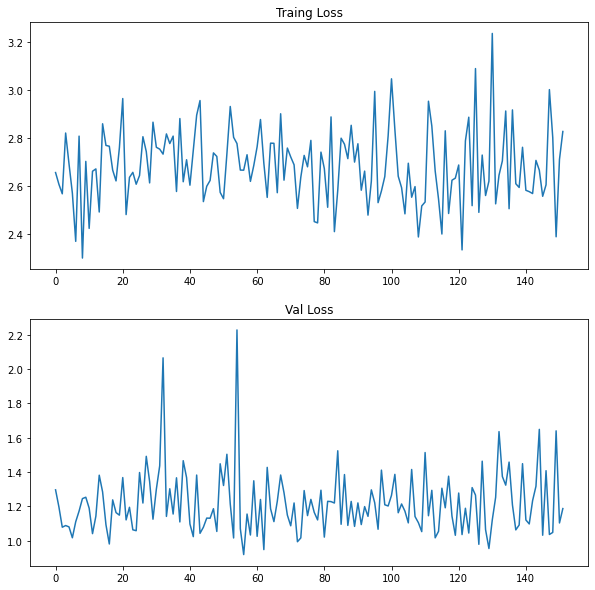

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_losses[1000:])
plt.title('Traing Loss')

plt.subplot(212)
plt.plot(val_losses[1000:])
plt.title('Val Loss')

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [12]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 
save_pred(preds, 'pred.csv')         

100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 849.32it/s]


# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)